## Part 1 - COVID Dataset: Implementing Fully Connected Deep Neural Networks

In [30]:
import sys
import tensorflow as tf

In [31]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.decomposition import PCA
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

#### Feature Description
##### • Day: Date in January 2021 ranging from Jan 2 to Jan 31.
##### • State ID: Arbitrary ID number for each state, based on alphabetical order. Note there are 51 states since the District of Columbia is also included.
##### • State: Name of the US State.
##### • Lat: Latitude for the geographic centre of the state.
##### • Long : Longitude for the geographic centre of the state.
##### • Active: Number of active, tracked COVID-19 cases that day in that state.
##### • Incident Rate: cases per 100,000 persons
##### • Total Test Results: Total number of people who have been tested
##### • Case Fatality Ratio(%): Number recorded deaths / Number cases.
##### • Testing Rate: Total test results per 100,000 persons
##### • Resident Population 2021 Census: see original data source
##### • Population Density 2021 Census: see original data source
##### • Density Rank 2021 Census: see original data source
##### • SexRatio: see original data source

### 2.1 [CM1] Data Preprocessing

The data preprocessing steps have been similar to the steps we have used in our earlier assignment, and they are as follows:
1. Checking for Missing values in Columns.
2. Checking for duplicate records and dropping it if any.
3. Removing features that are highly dependent upon each other. In Covid Dataset we have [State ID], so we do not need [State, Long, Lat] and dropping these features.
4. Type Casting the [Resident Population 2020 Census] and [Population Density 2020 Census] data into float data type.
5. Adding the relative difference of specific quanititative attributes with respect to the state.
6. Checking for outliers - Data point that differs significantly from other observations.By plotting Histograms, we look at data distribution for a variable and find values that fall outside the distribution.
7. Performing Z Score Regularization - score helps to understand if a data value is greater or smaller than mean and how far away it is from the mean. If the Z score of a data point is more than 3, it indicates that the data point is quite different from the other data points. Such a data point can be an outlier. 
8. Applying PCA on the covid features and creating a hybrid dataset with a combination of original features along with first five PCA components.

In [32]:
df = pd.read_csv('dkmacovid_train.csv')

In [33]:
df.sample(10)

,Day,State ID,State,Lat,Long_,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Confirmed,Deaths,Recovered
989,23,26,Missouri,38.4561,-92.2884,452974,7490.890321,4031558,1.473416,65688.06999,"6,154,913",89.5,30,96,True,True,False
501,12,46,Vermont,44.0459,-72.7107,2863,1481.917149,767325,1.708662,122970.91780,"643,077",69.8,33,97,True,True,True
1229,28,36,Ohio,40.3888,-82.7649,108230,7560.171442,8921429,1.245423,76322.63391,"11,799,448",288.8,12,96,True,True,True
668,16,27,Montana,46.9219,-110.4544,5048,8332.506844,874943,1.221703,81863.86696,"1,084,225",7.4,50,101,True,True,True
140,5,3,Arizona,33.7298,-111.4312,477855,7796.346526,5324030,1.641837,40580.39350,"7,151,502",62.9,35,99,True,True,True
66,3,23,Michigan,43.3266,-84.5361,161204,5388.291832,8122575,2.472678,81332.64550,"10,077,331",178,20,97,False,False,False
1342,31,9,District of Columbia,38.8974,-77.0268,10149,5224.520332,1100466,2.476134,155928.80760,"689,545","11,280.00",1,96,True,True,True
428,11,17,Kansas,38.5266,-96.7265,240502,8534.816364,1066516,1.306275,36608.34363,"2,937,880",35.9,43,99,True,True,True
813,19,34,North Carolina,35.6301,-79.8064,96785,6526.425608,8186392,1.189048,78054.21848,"10,439,388",214.7,17,95,True,True,True
1281,29,42,South Dakota,44.2998,-99.4388,3060,12203.007030,400824,1.637719,45308.30523,"886,667",11.7,48,102,True,True,True


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Day                              1380 non-null   int64  
 1   State ID                         1380 non-null   int64  
 2   State                            1380 non-null   object 
 3   Lat                              1380 non-null   float64
 4   Long_                            1380 non-null   float64
 5   Active                           1380 non-null   int64  
 6   Incident_Rate                    1380 non-null   float64
 7   Total_Test_Results               1380 non-null   int64  
 8   Case_Fatality_Ratio              1380 non-null   float64
 9   Testing_Rate                     1380 non-null   float64
 10  Resident Population 2020 Census  1380 non-null   object 
 11  Population Density 2020 Census   1380 non-null   object 
 12  Density Rank 2020 Ce

In [35]:
#checking for null values
df.isnull().sum()

Day                                0
State ID                           0
State                              0
Lat                                0
Long_                              0
Active                             0
Incident_Rate                      0
Total_Test_Results                 0
Case_Fatality_Ratio                0
Testing_Rate                       0
Resident Population 2020 Census    0
Population Density 2020 Census     0
Density Rank 2020 Census           0
SexRatio                           0
Confirmed                          0
Deaths                             0
Recovered                          0
dtype: int64

In [36]:
#Checking for duplicate rows
duplicated = df.duplicated().sum()
if duplicated:
    print('Duplicates in the Covid dataset are: {}'.format(duplicated))
else:
    print('Dataset does not contain any duplicate values.')

Dataset does not contain any duplicate values.


In [37]:
#Provides the previous and current data record of a list with respect to index
def neighbor(iterable):
    iterator = iter(iterable)
    previous_item = None
    current_item = next(iterator)
    for next_item in iterator:
        yield(previous_item, current_item)
        previous_item = current_item
        current_item = next_item
    yield(previous_item, current_item)

#Utilities used in Pre-processing of the data
def ReativeFeature(dataFrame, feature):
    new_feature = "Relative_" + feature 
    dataFrame[new_feature] = np.nan
    states = dataFrame.State.unique()
    for state in states:
        df_state = dataFrame[dataFrame['State'] == state]
        feature_state = df_state[feature].tolist()
        diff_feature =[]
        for previous, current in neighbor(feature_state):
            if(previous== None):
                diff_feature.append(1)
            else:
                diff_feature.append((current - previous))
        dataFrame.loc[(dataFrame['State'] == state), new_feature] = diff_feature
    return dataFrame

# Getting the relative difference values for specific quantitative attributes with respect to the state
df = ReativeFeature(df, 'Active')
df = ReativeFeature(df, 'Case_Fatality_Ratio')
df = ReativeFeature(df, 'Incident_Rate')
df = ReativeFeature(df, 'Total_Test_Results')
df = ReativeFeature(df, 'Testing_Rate')

df

,Day,State ID,State,Lat,Long_,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,...,Density Rank 2020 Census,SexRatio,Confirmed,Deaths,Recovered,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
0,2,1,Alabama,32.3182,-86.9023,162449,7535.061394,1891468,1.318688,38576.31315,...,29,94,True,False,False,1.0,1.000000,1.000000,1.0,1.00000
1,2,2,Alaska,61.3707,-152.4044,40421,6534.252848,1290349,0.449781,176386.82510,...,52,109,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
2,2,3,Arizona,33.7298,-111.4312,452222,7407.212013,5218721,1.680608,39916.14181,...,35,99,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
3,2,4,Arkansas,34.9697,-92.3731,24012,7669.219075,2079788,1.611203,68917.26567,...,36,96,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
4,2,5,California,36.1162,-119.6816,2362015,6045.109130,33391442,1.111215,84509.14544,...,13,99,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,31,46,Vermont,44.0459,-72.7107,3537,1917.501751,897351,1.454242,143808.78510,...,33,97,True,True,True,-26.0,-0.008019,21.474738,7674.0,1229.82940
1376,31,47,Virginia,37.7693,-78.1700,457993,5913.864172,5234155,1.280560,61322.04732,...,16,97,True,True,True,1413.0,-0.003536,29.968887,23920.0,280.24072
1377,31,49,West Virginia,38.4912,-80.9545,21195,6751.734093,1945579,1.672713,108561.35130,...,31,98,True,True,True,-612.0,-0.001709,36.883135,8719.0,486.51150
1378,31,50,Wisconsin,44.2685,-89.6165,68537,10169.973590,6177575,1.086567,106099.52810,...,27,99,True,True,True,-285.0,-0.001425,19.630970,22737.0,390.50680


In [38]:
#Removing features that are highly dependant upon each other. For example, we have state ID,
#thus we do not need state names, latitutde and longitude measures.

covid = df.copy(deep=True)
covid = covid.drop('Lat', axis=1)
covid = covid.drop('Long_', axis=1)
covid = covid.drop('State', axis=1)

In [39]:
covid

,Day,State ID,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Confirmed,Deaths,Recovered,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
0,2,1,162449,7535.061394,1891468,1.318688,38576.31315,"5,024,279",99.2,29,94,True,False,False,1.0,1.000000,1.000000,1.0,1.00000
1,2,2,40421,6534.252848,1290349,0.449781,176386.82510,"733,391",1.3,52,109,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
2,2,3,452222,7407.212013,5218721,1.680608,39916.14181,"7,151,502",62.9,35,99,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
3,2,4,24012,7669.219075,2079788,1.611203,68917.26567,"3,011,524",57.9,36,96,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
4,2,5,2362015,6045.109130,33391442,1.111215,84509.14544,"39,538,223",253.7,13,99,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,31,46,3537,1917.501751,897351,1.454242,143808.78510,"643,077",69.8,33,97,True,True,True,-26.0,-0.008019,21.474738,7674.0,1229.82940
1376,31,47,457993,5913.864172,5234155,1.280560,61322.04732,"8,631,393",218.6,16,97,True,True,True,1413.0,-0.003536,29.968887,23920.0,280.24072
1377,31,49,21195,6751.734093,1945579,1.672713,108561.35130,"1,793,716",74.6,31,98,True,True,True,-612.0,-0.001709,36.883135,8719.0,486.51150
1378,31,50,68537,10169.973590,6177575,1.086567,106099.52810,"5,893,718",108.8,27,99,True,True,True,-285.0,-0.001425,19.630970,22737.0,390.50680


In [40]:
#Type-casting the population and population density data into float data type
covid[['Resident Population 2020 Census', 'Population Density 2020 Census']] = covid[['Resident Population 2020 Census', 
                                                                                      'Population Density 2020 Census']].replace({",":""},
                                                                                       regex=True).apply(pd.to_numeric,1)
covid.describe()

,Day,State ID,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
count,1380.000000,1380.000000,1.380000e+03,1380.000000,1.380000e+03,1380.000000,1380.000000,1.380000e+03,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,16.500000,25.239130,2.610390e+05,7203.192905,5.271097e+06,1.631757,91763.237514,5.906191e+06,454.834783,27.173913,97.760870,2125.057971,0.032306,51.506535,34294.601449,555.077024
std,8.658579,14.513405,4.914059e+05,2305.025102,6.991478e+06,0.656702,40858.185997,6.858898e+06,1638.774933,15.378197,3.219219,7209.638027,0.180632,39.730615,59443.432853,679.818836
min,2.000000,1.000000,9.550000e+02,1232.233261,3.739460e+05,0.439598,30524.071590,5.768510e+05,1.300000,1.000000,94.000000,-78446.000000,-0.401078,-39.851523,-175618.000000,-4925.774500
25%,9.000000,12.000000,2.731600e+04,6042.134459,1.310515e+06,1.246993,67457.197525,1.455271e+06,44.100000,13.000000,95.000000,0.000000,-0.005693,27.924939,5235.500000,210.801003
50%,16.500000,25.500000,1.005915e+05,7453.675955,2.919566e+06,1.499993,85438.613770,4.098304e+06,103.500000,28.500000,97.000000,621.000000,-0.000398,47.003211,13717.500000,457.821910
75%,24.000000,37.000000,2.592418e+05,8621.924085,6.093790e+06,1.817013,104509.453475,7.029917e+06,253.700000,41.000000,99.000000,3120.750000,0.005113,68.112895,39626.500000,740.012500
max,31.000000,51.000000,3.283336e+06,12811.162350,4.227902e+07,3.928767,235733.711200,3.953822e+07,11280.000000,52.000000,109.000000,61334.000000,1.000000,695.695544,473076.000000,11903.445700


In [41]:
#Extracting covid features and separating labels
covid_features = covid[covid.columns.difference(['Confirmed', 'Deaths', 'Recovered'])]
covid_features

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,Relative_Total_Test_Results,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results
0,162449,1.318688,2,29,7535.061394,99.2,1.0,1.000000,1.000000,1.00000,1.0,5024279.0,94,1,38576.31315,1891468
1,40421,0.449781,2,52,6534.252848,1.3,1.0,1.000000,1.000000,1.00000,1.0,733391.0,109,2,176386.82510,1290349
2,452222,1.680608,2,35,7407.212013,62.9,1.0,1.000000,1.000000,1.00000,1.0,7151502.0,99,3,39916.14181,5218721
3,24012,1.611203,2,36,7669.219075,57.9,1.0,1.000000,1.000000,1.00000,1.0,3011524.0,96,4,68917.26567,2079788
4,2362015,1.111215,2,13,6045.109130,253.7,1.0,1.000000,1.000000,1.00000,1.0,39538223.0,99,5,84509.14544,33391442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3537,1.454242,31,33,1917.501751,69.8,-26.0,-0.008019,21.474738,1229.82940,7674.0,643077.0,97,46,143808.78510,897351
1376,457993,1.280560,31,16,5913.864172,218.6,1413.0,-0.003536,29.968887,280.24072,23920.0,8631393.0,97,47,61322.04732,5234155
1377,21195,1.672713,31,31,6751.734093,74.6,-612.0,-0.001709,36.883135,486.51150,8719.0,1793716.0,98,49,108561.35130,1945579
1378,68537,1.086567,31,27,10169.973590,108.8,-285.0,-0.001425,19.630970,390.50680,22737.0,5893718.0,99,50,106099.52810,6177575


In [42]:
#Scaling the original features dataframe while excluding Day column from scaling
scaler = preprocessing.StandardScaler()
scaled_features=covid_features.copy(deep = True)
scaled_features[['Active','Case_Fatality_Ratio','Incident_Rate', 
                 'Density Rank 2020 Census','Population Density 2020 Census',
                 'Relative_Active', 'Relative_Case_Fatality_Ratio','Total_Test_Results',
                 'Relative_Incident_Rate','Relative_Testing_Rate', 
                 'Testing_Rate', 'Resident Population 2020 Census', 
                 'Relative_Total_Test_Results', 'State ID','SexRatio']]=pd.DataFrame(scaler.fit_transform(scaled_features[['Active','Case_Fatality_Ratio',                              
                                                    'Incident_Rate', 'Density Rank 2020 Census',                           
                                                    'Population Density 2020 Census',
                                                    'Relative_Active', 'Relative_Case_Fatality_Ratio',
                                                    'Total_Test_Results','Relative_Incident_Rate', 
                                                    'Relative_Testing_Rate', 
                                                    'Testing_Rate', 'Resident Population 2020 Census', 
                                                    'Relative_Total_Test_Results','State ID','SexRatio']]))
scaled_features.shape

(1380, 16)

In [43]:
#PCA Implementation
def implement_PCA(components, data, svd_solver='auto'):
    pca = PCA(n_components = components, svd_solver=svd_solver)
    Principal_Components = pca.fit_transform(data)
    df_pca = pd.DataFrame(data = Principal_Components)
    return(df_pca, pca)

def PCA_ScreePlot(pca):
    pc_value = np.arange(pca.n_components_) + 1
    plt.figure(figsize=(15,8)) 
    plt.plot(pc_value, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.grid()
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of variance explained')
    plt.locator_params(axis="y", nbins=25)
    plt.show()
    
#Applying PCA with n_components = 10
pca_implement = implement_PCA(components = 10, data=scaled_features)
pca_features_covid = pca_implement[0]
pca_covid_data = pca_implement[1]

In [44]:
#Making the hybrid dataset by using non-scaled covid_train dataset along with its first 5 PCA components.
x = pca_features_covid[0].tolist()
scaled_features.loc[:, 'PCA1'] = x
x = pca_features_covid[1].tolist()
scaled_features.loc[:, 'PCA2'] = x
x = pca_features_covid[2].tolist()
scaled_features.loc[:, 'PCA3'] = x
x = pca_features_covid[3].tolist()
scaled_features.loc[:, 'PCA4'] = x
x = pca_features_covid[4].tolist()
scaled_features.loc[:, 'PCA5'] = x

scaled_features.dropna(subset =['Active', 'Incident_Rate'], how ='all')

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,...,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results,PCA1,PCA2,PCA3,PCA4,PCA5
0,-0.200701,-0.476902,2,0.118788,0.144028,-0.217091,-0.294720,5.359204,-1.271685,-0.815332,...,-0.128626,-1.168679,-1.670726,-1.302217,-0.483568,14.666646,-0.949980,-0.349984,-3.707411,-1.323980
1,-0.449116,-1.800519,2,1.614954,-0.290315,-0.276853,-0.294720,5.359204,-1.271685,-0.815332,...,-0.754447,3.492526,-1.601799,2.071905,-0.569578,14.626733,-2.756834,-2.134700,-1.144711,-5.334053
2,0.389194,0.074416,2,0.509092,0.088543,-0.239250,-0.294720,5.359204,-1.271685,-0.815332,...,0.181627,0.385056,-1.532872,-1.269412,-0.007494,14.662782,-0.721479,-1.106860,-3.480463,-2.109991
3,-0.482520,-0.031311,2,0.574143,0.202252,-0.242302,-0.294720,5.359204,-1.271685,-0.815332,...,-0.422184,-0.547185,-1.463945,-0.559356,-0.456622,14.656176,-1.332908,-0.282641,-3.171700,-1.962535
4,4.276989,-0.792949,2,-0.922023,-0.502599,-0.122779,-0.294720,5.359204,-1.271685,-0.815332,...,4.905194,0.385056,-1.395018,-0.177608,4.023547,14.619971,4.800026,-2.893041,-4.651823,-3.576935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,-0.524201,-0.270412,31,0.378991,-2.293948,-0.235038,-0.298467,-0.223324,-0.756160,0.992907,...,-0.767619,-0.236438,1.430980,1.274271,-0.625809,-14.470254,-1.158565,1.437137,0.283401,-0.524878
1376,0.400942,-0.534982,31,-0.726871,-0.559558,-0.144206,-0.098801,-0.198497,-0.542288,-0.404425,...,0.397468,-0.236438,1.499907,-0.745315,-0.005286,-14.475159,0.032817,-0.107686,-1.095437,0.756428
1377,-0.488254,0.062389,31,0.248890,-0.195930,-0.232108,-0.379776,-0.188381,-0.368197,-0.100895,...,-0.599800,0.074309,1.637761,0.411281,-0.475825,-14.491971,-1.276133,0.440023,0.024388,0.180305
1378,-0.391879,-0.830494,31,-0.011313,1.287559,-0.211231,-0.334404,-0.186806,-0.802583,-0.242167,...,-0.001819,0.385056,1.706687,0.351006,0.129702,-14.539498,-0.974469,-0.675981,0.088166,-0.228151


### 2.2 Deep Neural Networks

#### Network design: We have chosen to use our data as is, with three networks making binary classification decisions for each datapoint

### CM2: Default network

In [45]:
X_train = scaled_features.copy()
y_train = covid.copy()
y_train = y_train[y_train.columns.difference(['Day', 'State ID', 'Active', 'Incident_Rate', 'Total_Test_Results',
                                             'Case_Fatality_Ratio', 'Testing_Rate', 'Resident Population 2020 Census',
                                              'Population Density 2020 Census', 'Density Rank 2020 Census', 
                                              'Relative_Active', 'Relative_Case_Fatality_Ratio',
                                              'Relative_Incident_Rate', 'Relative_Total_Test_Results',
                                              'Relative_Testing_Rate', 'zscore_incident_rate',
                                              'zscore_Case_Fatality_Ratio','SexRatio'])]

In [46]:
#Checking for X_train shape
X_train.shape

(1380, 21)

In [47]:
#Checking for y_train shape
y_train.shape

(1380, 3)

In [48]:
#Split the Train dataset into train and test data (taking 15% for testing):
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.15, random_state = 0, 
                                                    shuffle=True)

In [49]:
#Split the Train dataset into train and validation data (taking 10% for testing):
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train1, y_train1, test_size=0.10, random_state=0, shuffle=True)

In [50]:
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train2.shape))
print('y_train:\t{}'.format(y_train2.shape))
print('X_validation:\t{}'.format(X_val2.shape))
print('y_validation:\t{}'.format(y_val2.shape))
print('X_test:\t{}'.format(X_test1.shape))
print('y_test:\t{}'.format(y_test1.shape))

X_train:	(1055, 21)
y_train:	(1055, 3)
X_validation:	(118, 21)
y_validation:	(118, 3)
X_test:	(207, 21)
y_test:	(207, 3)


In [51]:
#Separating y-train, y-test and y-val for the three labels: Recovered, Deaths, Confirmed
y_train_Recovered = y_train2.copy()
y_train_Recovered = y_train2[y_train2.columns.difference(['Confirmed', 'Deaths'])]
y_train_Confirmed = y_train2.copy()
y_train_Confirmed = y_train2[y_train2.columns.difference(['Recovered', 'Deaths'])]
y_train_Deaths = y_train2.copy()
y_train_Deaths = y_train2[y_train2.columns.difference(['Recovered', 'Confirmed'])]

y_val_Recovered = y_val2.copy()
y_val_Recovered = y_val2[y_val2.columns.difference(['Confirmed', 'Deaths'])]
y_val_Confirmed = y_val2.copy()
y_val_Confirmed = y_val2[y_val2.columns.difference(['Recovered', 'Deaths'])]
y_val_Deaths = y_val2.copy()
y_val_Deaths = y_val2[y_val2.columns.difference(['Recovered', 'Confirmed'])]

y_test_Recovered = y_test1.copy()
y_test_Recovered = y_test1[y_test1.columns.difference(['Confirmed', 'Deaths'])]
y_test_Confirmed = y_test1.copy()
y_test_Confirmed = y_test1[y_test1.columns.difference(['Recovered', 'Deaths'])]
y_test_Deaths = y_test1.copy()
y_test_Deaths = y_test1[y_test1.columns.difference(['Recovered', 'Confirmed'])]

In [52]:
y_train_Recovered = y_train_Recovered.astype(int)
y_train_Confirmed = y_train_Confirmed.astype(int)
y_train_Deaths = y_train_Deaths.astype(int)

y_val_Recovered = y_val_Recovered.astype(int)
y_val_Confirmed = y_val_Confirmed.astype(int)
y_val_Deaths = y_val_Deaths.astype(int)

y_test_Recovered = y_test_Recovered.astype(int)
y_test_Confirmed = y_test_Confirmed.astype(int)
y_test_Deaths = y_test_Deaths.astype(int)

### Building the default Deep Neural Network Model for Recovered labels

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                440       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________
None
Total time:  8.649215936660767 seconds
Train accuracy for default DNN model on Recovered labels: 0.960,Validation accuracy for default DNN model on Recovered labels: 0.915
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


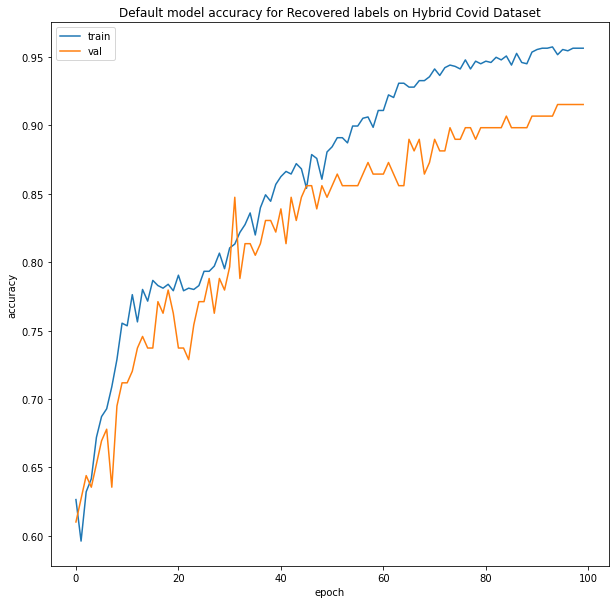

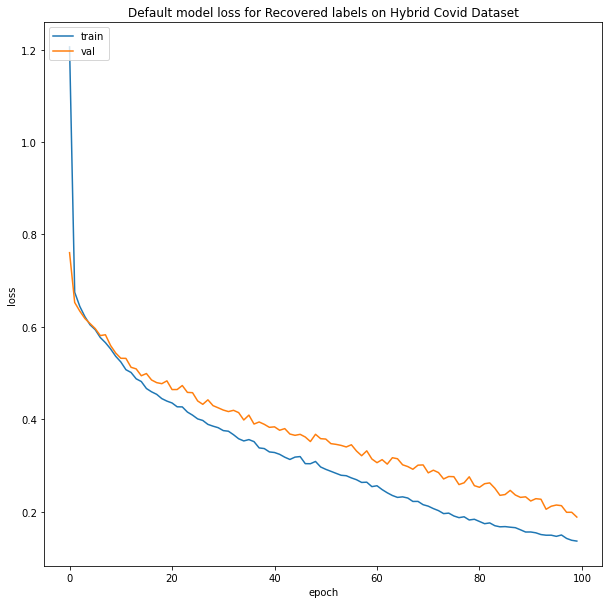

In [37]:
import time #For calculating the time taken to train the model

input_shape = X_train2.shape[1]
out_shape = y_train_Recovered.shape[1]

default_model_Recovered = Sequential([
    layers.Dense(20, activation='relu', input_shape=(input_shape,) ),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

default_model_Recovered.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(default_model_Recovered.summary())

# fit the network
start = time.time()
history = default_model_Recovered.fit(X_train2,y_train_Recovered, epochs = 100,
                            validation_data=(X_val2,y_val_Recovered), 
                            verbose=0, batch_size=50)
print("Total time: ", time.time() - start, "seconds")

#Evaluating the model on training and validation dataset
_, train_acc = default_model_Recovered.evaluate(X_train2,y_train_Recovered, verbose=0)
_, validation_acc = default_model_Recovered.evaluate(X_val2,y_val_Recovered, verbose=0)
print('Train accuracy for default DNN model on Recovered labels: %.3f,Validation accuracy for default DNN model on Recovered labels: %.3f' % (train_acc, validation_acc))

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
figure_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Default model accuracy for Recovered labels on Hybrid Covid Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_acc.savefig("default_model_accuracy_Recovered.png")

# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Default model loss for Recovered labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("default_model_loss_Recovered.png")

In [38]:
#Evaluating the default DNN model on the test dataset for Recovered class labels
default_model_Recovered.evaluate(X_test1, y_test_Recovered, batch_size=50)

207/207 [==============================] - 0s 65us/sample - loss: 0.1913 - accuracy: 0.9517


[0.19134189857952838, 0.9516908]

### Building the default Deep Neural Network Model for Deaths labels

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                440       
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________
None
Total time:  9.161099195480347 seconds
Train accuracy for default DNN model on Deaths labels: 0.955,Validation accuracy for default DNN model on Deaths labels: 0.932
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


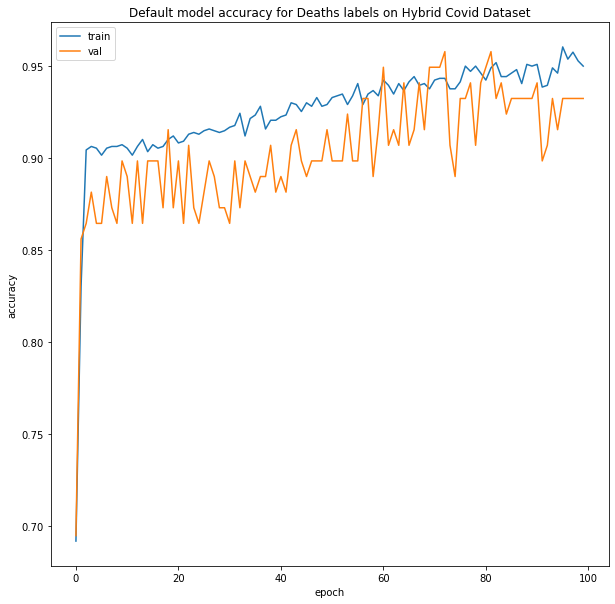

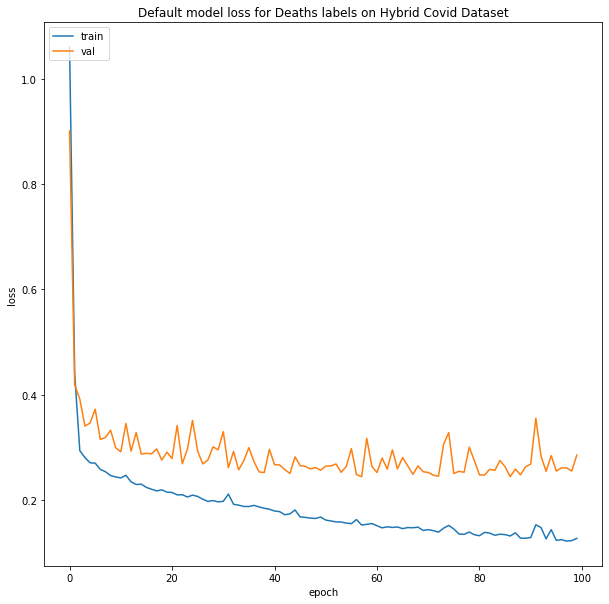

In [52]:
input_shape = X_train2.shape[1]
out_shape = y_train_Deaths.shape[1]

default_model_Deaths = Sequential([
    layers.Dense(20, activation='relu', input_shape=(input_shape,) ),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

default_model_Deaths.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(default_model_Deaths.summary())

# fit the network
start = time.time()
history = default_model_Deaths.fit(X_train2,y_train_Deaths, epochs = 100,
                            validation_data=(X_val2,y_val_Deaths), 
                            verbose=0, batch_size=50)
print("Total time: ", time.time() - start, "seconds")

#Evaluating the model on training and validation dataset
_, train_acc = default_model_Deaths.evaluate(X_train2,y_train_Deaths, verbose=0)
_, validation_acc = default_model_Deaths.evaluate(X_val2,y_val_Deaths, verbose=0)
print('Train accuracy for default DNN model on Deaths labels: %.3f,Validation accuracy for default DNN model on Deaths labels: %.3f' % (train_acc, validation_acc))

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
figure_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Default model accuracy for Deaths labels on Hybrid Covid Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_acc.savefig("default_model_accuracy_Deaths.png")

# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Default model loss for Deaths labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("default_model_loss_Deaths.png")

In [53]:
#Evaluating the default DNN model on the test dataset for Deaths class labels
default_model_Deaths.evaluate(X_test1, y_test_Deaths, batch_size=50)

207/207 [==============================] - 0s 108us/sample - loss: 0.3353 - accuracy: 0.9082


[0.3353420764135854, 0.90821254]

### Building the default Deep Neural Network Model for Confirmed labels

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                440       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________
None
Total time:  9.14232587814331 seconds
Train accuracy for default DNN model on Confirmed labels: 0.995,Validation accuracy for default DNN model on Confirmed labels: 0.983
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


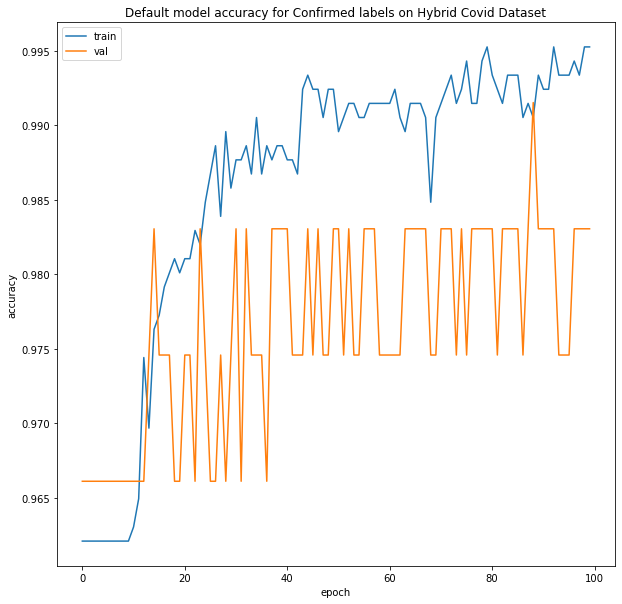

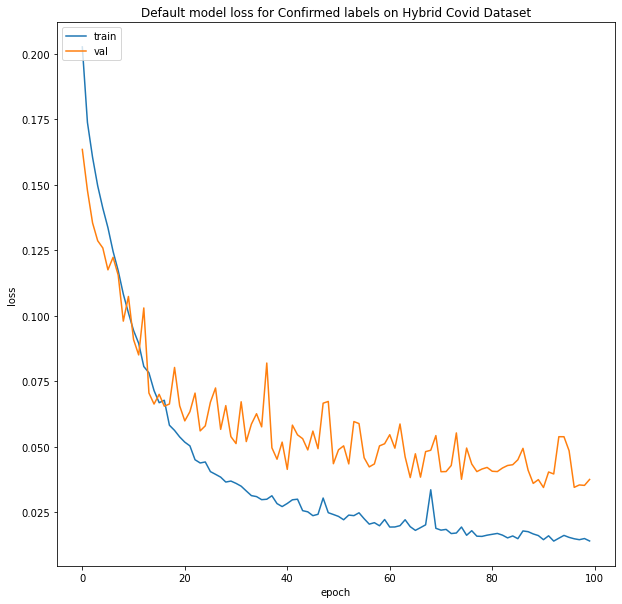

In [63]:
input_shape = X_train2.shape[1]
out_shape = y_train_Confirmed.shape[1]

default_model_Confirmed = Sequential([
    layers.Dense(20, activation='relu', input_shape=(input_shape,) ),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

default_model_Confirmed.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(default_model_Confirmed.summary())

# fit the network
start = time.time()
history = default_model_Confirmed.fit(X_train2,y_train_Confirmed, epochs = 100,
                            validation_data=(X_val2,y_val_Confirmed), 
                            verbose=0, batch_size=50)
print("Total time: ", time.time() - start, "seconds")

#Evaluating the model on training and validation dataset
_, train_acc = default_model_Confirmed.evaluate(X_train2,y_train_Confirmed, verbose=0)
_, validation_acc = default_model_Confirmed.evaluate(X_val2,y_val_Confirmed, verbose=0)
print('Train accuracy for default DNN model on Confirmed labels: %.3f,Validation accuracy for default DNN model on Confirmed labels: %.3f' % (train_acc, validation_acc))

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
figure_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Default model accuracy for Confirmed labels on Hybrid Covid Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_acc.savefig("default_model_accuracy_Confirmed.png")

# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Default model loss for Confirmed labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("default_model_loss_Confirmed.png")

In [64]:
#Evaluating the default DNN model on the test dataset for Confirmed class labels
default_model_Confirmed.evaluate(X_test1, y_test_Confirmed, batch_size=50)

207/207 [==============================] - 0s 93us/sample - loss: 0.1013 - accuracy: 0.9903


[0.10131273884776133, 0.99033815]

### [CM3] Implementing my own DNN network for classification on the hybrid COVID dataset

###  Model 1: LSTM model implementation

#### Creating a sequence for LSTM implementation from our dataset

In [69]:
def gen_sequences(input_array, label_array=None, seq_len=3):
    seq = []
    labels = []
    for k in range(len(input_array)):
        if k < seq_len:
            n_zeros = seq_len-k-1
            # Since we're generating sequnces we need to pad the first seq_len-1 values to ensure we don't lose any values
            b = np.zeros((n_zeros, *input_array.shape[1:]))
            a = np.array(input_array[:k+1])
            b = np.concatenate((a, b), axis=0)
        else:
            b = np.array(input_array[k-seq_len:k])
        seq.append(b)
        
    if label_array is not None:
        assert(len(seq) == len(label_array))
    
    return np.array(seq), label_array
    

In [71]:
from tensorflow.keras.layers import LSTM

df_covid_train = scaled_features
df_covid_train = df_covid_train.join(covid[['Recovered', 'Deaths', 'Confirmed']])
df_covid_train = df_covid_train.sort_values(by=['Day'])
df_covid_train.dropna(subset =['Active', 'Incident_Rate'], how ='all')

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,...,Testing_Rate,Total_Test_Results,PCA1,PCA2,PCA3,PCA4,PCA5,Recovered,Deaths,Confirmed
0,-0.200701,-0.476902,2,0.118788,0.144028,-0.217091,-0.294720,5.359204,-1.271685,-0.815332,...,-1.302217,-0.483568,14.666646,-0.949980,-0.349984,-3.707411,-1.323980,False,False,True
25,-0.415593,-0.974694,2,1.159599,0.648896,-0.262080,-0.294720,5.359204,-1.271685,-0.815332,...,-0.011355,-0.501505,14.635994,-2.186794,-1.352494,-2.209420,-2.649691,True,True,True
26,-0.071893,-0.404950,2,1.094549,0.121137,-0.260371,-0.294720,5.359204,-1.271685,-0.815332,...,-0.568259,-0.452076,14.655486,-1.900713,-1.311387,-2.574969,-2.474566,False,True,True
27,-0.518189,0.105633,2,-0.271516,-1.683245,-0.183762,-0.294720,5.359204,-1.271685,-0.815332,...,-0.386756,-0.606410,14.699237,-1.436135,0.570430,-3.267850,-2.006104,True,True,True
28,0.308555,3.499064,2,-1.637581,-0.739897,0.493331,-0.294720,5.359204,-1.271685,-0.815332,...,-0.097128,0.361589,14.668859,0.976853,2.445898,-3.934573,-1.897504,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,-0.477811,-0.200165,31,0.834346,-1.856514,-0.250665,-0.274740,-0.212010,-1.004658,-0.799726,...,0.260654,-0.557237,-14.458179,-1.290572,0.588575,-1.374965,0.019683,True,False,True
1352,0.156359,0.577081,31,-1.312327,-0.581527,0.110650,-0.056342,-0.202664,-0.569286,0.308431,...,0.593474,0.249259,-14.499287,1.015129,1.579388,-0.729825,0.029230,True,True,True
1353,-0.287663,1.751779,31,-1.442429,0.173438,0.272476,0.068536,-0.208801,-0.323327,1.188297,...,2.596012,1.196433,-14.551212,2.120573,2.529316,0.746013,-1.217743,False,True,True
1343,2.918928,-0.142448,31,-1.117175,0.352189,-0.032618,0.769241,-0.179174,-0.383867,0.072110,...,-0.062830,1.986911,-14.529704,4.268644,-1.286699,-1.114500,-0.488106,False,True,True


### Recovered Label: LSTM Implementation

In [72]:
X_train1 = df_covid_train.drop(['Recovered', 'Deaths', 'Confirmed'], axis =1).values
Y_train1 = df_covid_train.copy()
Y_train1 = Y_train1[Y_train1.columns.difference(['Day', 'State ID', 'Active', 'Incident_Rate', 'Total_Test_Results',
                                             'Case_Fatality_Ratio', 'Testing_Rate', 'Resident Population 2020 Census',
                                              'Population Density 2020 Census', 'Density Rank 2020 Census', 
                                              'Relative_Active', 'Relative_Case_Fatality_Ratio',
                                              'Relative_Incident_Rate', 'Relative_Total_Test_Results',
                                              'Relative_Testing_Rate', 'zscore_incident_rate',
                                              'zscore_Case_Fatality_Ratio','SexRatio',
                                                 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5','Confirmed', 'Deaths'])]
Y_train1 = Y_train1.astype(int)
Y_train_lstm_recovered = Y_train1.values

In [73]:
X_train_lstm, Y_train_lstm = gen_sequences(X_train1, Y_train_lstm_recovered)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_lstm, Y_train_lstm,
                                                     test_size=0.15, 
                                                     random_state=0,
                                                     shuffle=True)
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train2, Y_train2,
                                                     test_size=0.10, 
                                                     random_state=0,
                                                     shuffle=True)
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train2.shape))
print('y_train:\t{}'.format(Y_train2.shape))
print('X_validation:\t{}'.format(X_val2.shape))
print('y_validation:\t{}'.format(Y_val2.shape))
print('X_test:\t{}'.format(X_test2.shape))
print('y_test:\t{}'.format(Y_test2.shape))

X_train:	(1055, 3, 21)
y_train:	(1055, 1)
X_validation:	(118, 3, 21)
y_validation:	(118, 1)
X_test:	(207, 3, 21)
y_test:	(207, 1)


In [75]:
in_shape = X_train2.shape[1:]
out_shape = Y_train2.shape[1]

LSTM_Model_Recovered = Sequential([
    tf.keras.layers.Bidirectional(LSTM(50, return_sequences = True )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

opt = optimizers.Adam(lr=0.001)
LSTM_Model_Recovered.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the network
history = LSTM_Model_Recovered.fit(X_train2, Y_train2, epochs=100, batch_size=256, validation_data=(X_val2,Y_val2))

# list all data in history
print(history.history.keys())


Train on 1055 samples, validate on 118 samples
Epoch 1/100


2021-08-08 22:33:43.295953: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_157537_158024' and '__inference___backward_standard_lstm_157537_158024_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_158152' both implement 'lstm_36a65e6a-809b-4e91-87d7-443e233aef00' but their signatures do not match.


1024/1055 [============================>.] - ETA: 0s - loss: 0.6886 - accuracy: 0.5391

2021-08-08 22:33:49.768565: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_158360' and '__inference_standard_lstm_158360_specialized_for_sequential_5_bidirectional_1_forward_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_159237' both implement 'lstm_7af44d85-55ba-4943-b6b6-f21023eabc47' but their signatures do not match.


1055/1055 [==============================] - 13s 12ms/sample - loss: 0.6880 - accuracy: 0.5441 - val_loss: 0.6814 - val_accuracy: 0.5763
Epoch 2/100
1055/1055 [==============================] - 0s 460us/sample - loss: 0.6705 - accuracy: 0.6152 - val_loss: 0.6776 - val_accuracy: 0.5763
Epoch 3/100
1055/1055 [==============================] - 0s 469us/sample - loss: 0.6569 - accuracy: 0.6341 - val_loss: 0.6785 - val_accuracy: 0.5763
Epoch 4/100
1055/1055 [==============================] - 0s 414us/sample - loss: 0.6564 - accuracy: 0.6303 - val_loss: 0.6801 - val_accuracy: 0.5763
Epoch 5/100
1055/1055 [==============================] - 1s 613us/sample - loss: 0.6514 - accuracy: 0.6303 - val_loss: 0.6808 - val_accuracy: 0.5763
Epoch 6/100
1055/1055 [==============================] - 1s 585us/sample - loss: 0.6522 - accuracy: 0.6294 - val_loss: 0.6804 - val_accuracy: 0.5763
Epoch 7/100
1055/1055 [==============================] - 0s 430us/sample - loss: 0.6493 - accuracy: 0.6341 - val_loss:

Epoch 56/100
1055/1055 [==============================] - 0s 392us/sample - loss: 0.4888 - accuracy: 0.7602 - val_loss: 0.5591 - val_accuracy: 0.7119
Epoch 57/100
1055/1055 [==============================] - 0s 389us/sample - loss: 0.4769 - accuracy: 0.7621 - val_loss: 0.5578 - val_accuracy: 0.6949
Epoch 58/100
1055/1055 [==============================] - 0s 388us/sample - loss: 0.4645 - accuracy: 0.7801 - val_loss: 0.5563 - val_accuracy: 0.6864
Epoch 59/100
1055/1055 [==============================] - 0s 390us/sample - loss: 0.4664 - accuracy: 0.7773 - val_loss: 0.5521 - val_accuracy: 0.7119
Epoch 60/100
1055/1055 [==============================] - 0s 391us/sample - loss: 0.4727 - accuracy: 0.7602 - val_loss: 0.5533 - val_accuracy: 0.7034
Epoch 61/100
1055/1055 [==============================] - 0s 381us/sample - loss: 0.4662 - accuracy: 0.7678 - val_loss: 0.5583 - val_accuracy: 0.7373
Epoch 62/100
1055/1055 [==============================] - 0s 375us/sample - loss: 0.4671 - accuracy:

In [76]:
# Model summary
LSTM_Model_Recovered.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection multiple                  28800     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_14 (Dense)             multiple                  1010      
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_15 (Dense)             multiple                  62        
Total params: 29,872
Trainable params: 29,872
Non-trainable params: 0
__________________________________________________

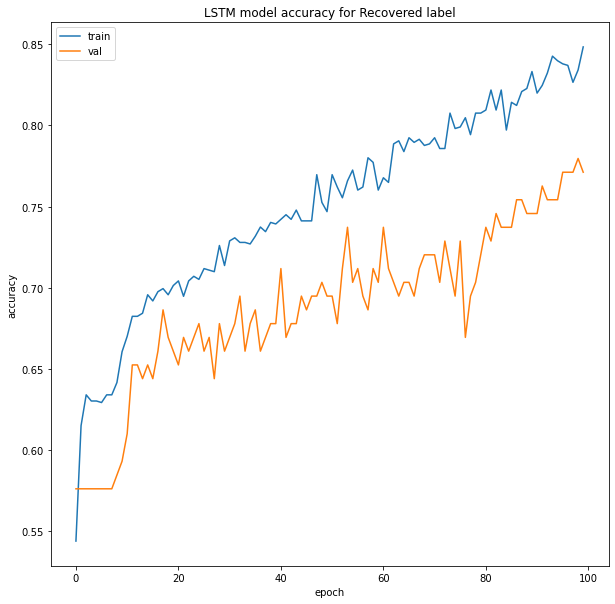

In [77]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy for Recovered label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_model_accuracy.png")

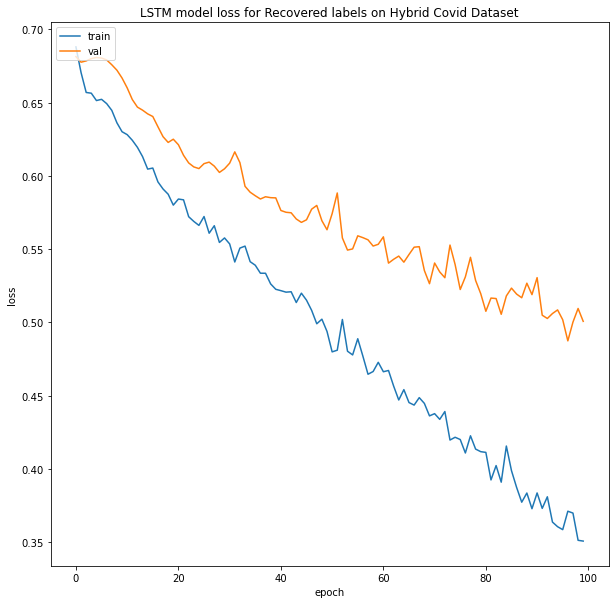

In [81]:
# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss for Recovered labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("LSTM_model_loss_Recovered.png")

In [78]:
#Checking accuracy on test data
LSTM_Model_Recovered.evaluate(X_test2, Y_test2, batch_size=20)

207/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4981375257462119, 0.73429954]

In [79]:
%%time
LSTM_Model_Recovered.evaluate(X_test2, Y_test2, batch_size=20)

207/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4981375257462119, 0.73429954]

### Deaths Label - LSTM Implementation

In [82]:
X_train3 = df_covid_train.drop(['Recovered', 'Deaths', 'Confirmed'], axis =1).values
Y_train3 = df_covid_train[['Deaths']]
Y_train3 = Y_train3.astype(int)
Y_train_lstm_deaths = Y_train3.values

In [83]:
X_train_lstm_Deaths, Y_train_lstm_deaths = gen_sequences(X_train3, Y_train_lstm_deaths)
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X_train_lstm_Deaths, Y_train_lstm_deaths,
                                                     test_size=0.15, 
                                                     random_state=0,
                                                     shuffle=True)
X_train4, X_val4, Y_train4, Y_val4 = train_test_split(X_train4, Y_train4,
                                                     test_size=0.10, 
                                                     random_state=0,
                                                     shuffle=True)
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train4.shape))
print('y_train:\t{}'.format(Y_train4.shape))
print('X_validation:\t{}'.format(X_val4.shape))
print('y_validation:\t{}'.format(Y_val4.shape))
print('X_test:\t{}'.format(X_test4.shape))
print('y_test:\t{}'.format(Y_test4.shape))

X_train:	(1055, 3, 21)
y_train:	(1055, 1)
X_validation:	(118, 3, 21)
y_validation:	(118, 1)
X_test:	(207, 3, 21)
y_test:	(207, 1)


In [85]:
in_shape = X_train4.shape[1:]
out_shape = Y_train4.shape[1]

LSTM_Model_Deaths = Sequential([
    tf.keras.layers.Bidirectional(LSTM(50, return_sequences = True, input_shape=in_shape )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

opt = optimizers.Adam(lr=0.001)
LSTM_Model_Deaths.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the network
history = LSTM_Model_Deaths.fit(X_train4, Y_train4, epochs=100, batch_size=256, validation_data=(X_val4,Y_val4))

# list all data in history
print(history.history.keys())

Train on 1055 samples, validate on 118 samples
Epoch 1/100


2021-08-08 22:40:46.958715: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_177478_177662' and '__inference___backward_standard_lstm_178412_178899_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_179027' both implement 'lstm_4ad2b39f-fa3d-4603-a64e-0c7060c79352' but their signatures do not match.


1024/1055 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.7891

2021-08-08 22:40:54.083777: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_179235' and '__inference_standard_lstm_179235_specialized_for_sequential_7_bidirectional_3_forward_lstm_3_StatefulPartitionedCall_at___inference_distributed_function_180112' both implement 'lstm_395f911b-332c-477f-938a-1d09e629f9dc' but their signatures do not match.


1055/1055 [==============================] - 13s 12ms/sample - loss: 0.5792 - accuracy: 0.7943 - val_loss: 0.4667 - val_accuracy: 0.8983
Epoch 2/100
1055/1055 [==============================] - 0s 463us/sample - loss: 0.4511 - accuracy: 0.8976 - val_loss: 0.3756 - val_accuracy: 0.8983
Epoch 3/100
1055/1055 [==============================] - 1s 531us/sample - loss: 0.3733 - accuracy: 0.9062 - val_loss: 0.3298 - val_accuracy: 0.8983
Epoch 4/100
1055/1055 [==============================] - 0s 409us/sample - loss: 0.3362 - accuracy: 0.9052 - val_loss: 0.3226 - val_accuracy: 0.8983
Epoch 5/100
1055/1055 [==============================] - 0s 415us/sample - loss: 0.3207 - accuracy: 0.9062 - val_loss: 0.3315 - val_accuracy: 0.8983
Epoch 6/100
1055/1055 [==============================] - 0s 436us/sample - loss: 0.3325 - accuracy: 0.9052 - val_loss: 0.3340 - val_accuracy: 0.8983
Epoch 7/100
1055/1055 [==============================] - 0s 426us/sample - loss: 0.3204 - accuracy: 0.9062 - val_loss:

1055/1055 [==============================] - 1s 523us/sample - loss: 0.2611 - accuracy: 0.9081 - val_loss: 0.3567 - val_accuracy: 0.8983
Epoch 56/100
1055/1055 [==============================] - 0s 402us/sample - loss: 0.2618 - accuracy: 0.9071 - val_loss: 0.3503 - val_accuracy: 0.8983
Epoch 57/100
1055/1055 [==============================] - 1s 510us/sample - loss: 0.2587 - accuracy: 0.9081 - val_loss: 0.3397 - val_accuracy: 0.8983
Epoch 58/100
1055/1055 [==============================] - 1s 493us/sample - loss: 0.2560 - accuracy: 0.9081 - val_loss: 0.3423 - val_accuracy: 0.8983
Epoch 59/100
1055/1055 [==============================] - 0s 431us/sample - loss: 0.2556 - accuracy: 0.9062 - val_loss: 0.3479 - val_accuracy: 0.8983
Epoch 60/100
1055/1055 [==============================] - 0s 432us/sample - loss: 0.2549 - accuracy: 0.9062 - val_loss: 0.3476 - val_accuracy: 0.8983
Epoch 61/100
1055/1055 [==============================] - 1s 495us/sample - loss: 0.2537 - accuracy: 0.9071 - val

In [86]:
# Model summary
LSTM_Model_Deaths.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection multiple                  28800     
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_18 (Dense)             multiple                  1010      
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  62        
Total params: 29,872
Trainable params: 29,872
Non-trainable params: 0
__________________________________________________

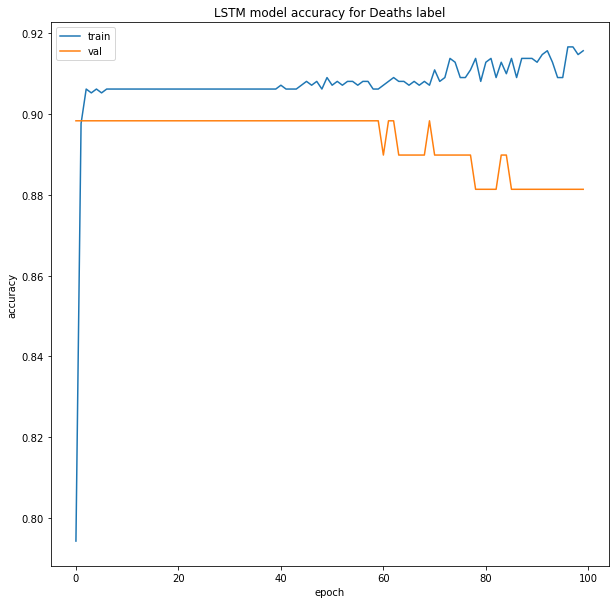

In [87]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy for Deaths label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_model_accuracy.png")

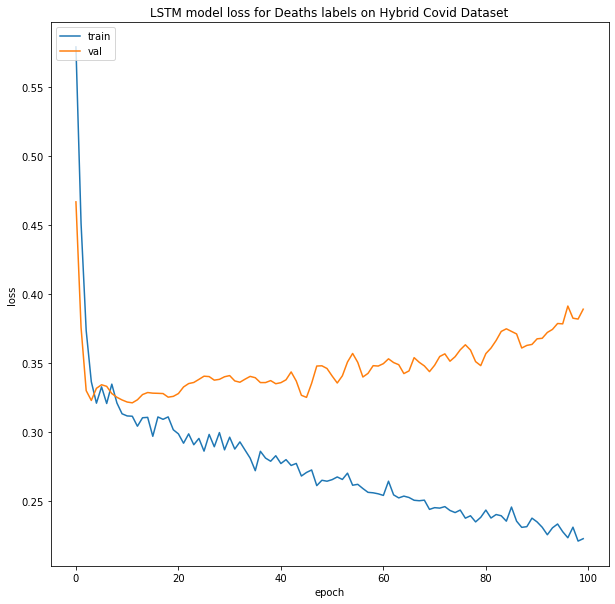

In [88]:
# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss for Deaths labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("LSTM_model_loss_Deaths.png")

In [90]:
#Checking accuracy on test data
LSTM_Model_Deaths.evaluate(X_test4, Y_test4, batch_size=20)

207/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4012954995252084, 0.87439615]

In [91]:
%%time
LSTM_Model_Deaths.evaluate(X_test4, Y_test4, batch_size=20)

207/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4012954995252084, 0.87439615]

### Confirmed Label - LSTM Implementation

In [92]:
X_train5 = df_covid_train.drop(['Recovered', 'Deaths', 'Confirmed'], axis =1).values
Y_train5 = df_covid_train[['Confirmed']]
Y_train5 = Y_train5.astype(int)
Y_train_lstm_confirmed = Y_train5.values
X_train_lstm_confirmed, Y_train_lstm_confirmed = gen_sequences(X_train5, Y_train_lstm_confirmed)
X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X_train_lstm_confirmed, Y_train_lstm_confirmed,
                                                     test_size=0.15, 
                                                     random_state=0,
                                                     shuffle=True)
X_train7, X_val7, Y_train7, Y_val7 = train_test_split(X_train6, Y_train6,
                                                     test_size=0.10, 
                                                     random_state=0,
                                                     shuffle=True)
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train7.shape))
print('y_train:\t{}'.format(Y_train7.shape))
print('X_validation:\t{}'.format(X_val7.shape))
print('y_validation:\t{}'.format(Y_val7.shape))
print('X_test:\t{}'.format(X_test6.shape))
print('y_test:\t{}'.format(Y_test6.shape))

X_train:	(1055, 3, 21)
y_train:	(1055, 1)
X_validation:	(118, 3, 21)
y_validation:	(118, 1)
X_test:	(207, 3, 21)
y_test:	(207, 1)


In [93]:
in_shape = X_train7.shape[1:]
out_shape = Y_train7.shape[1]

LSTM_Model_Confirmed = Sequential([
    tf.keras.layers.Bidirectional(LSTM(50, return_sequences = True )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

opt = optimizers.Adam(lr=0.001)
LSTM_Model_Confirmed.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the network
history = LSTM_Model_Confirmed.fit(X_train7, Y_train7, epochs=50, batch_size=28, validation_data=(X_val7,Y_val7))

# list all data in history
print(history.history.keys())

Train on 1055 samples, validate on 118 samples
Epoch 1/50


2021-08-08 22:44:35.416258: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_187970_188455_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_189118' and '__inference___backward_standard_lstm_187970_188455' both implement 'lstm_9479c637-ae15-4a7c-9f7e-1c1e49950605' but their signatures do not match.


1008/1055 [===========================>..] - ETA: 0s - loss: 0.4771 - accuracy: 0.8046

2021-08-08 22:44:41.329197: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_189536' and '__inference_standard_lstm_189425_specialized_for_sequential_8_bidirectional_4_forward_lstm_4_StatefulPartitionedCall_at___inference_distributed_function_190302' both implement 'lstm_dea26ad3-5abc-4eb8-8e82-3dbda8a22a79' but their signatures do not match.


1055/1055 [==============================] - 11s 10ms/sample - loss: 0.4629 - accuracy: 0.8123 - val_loss: 0.2272 - val_accuracy: 0.9576
Epoch 2/50
1055/1055 [==============================] - 1s 1ms/sample - loss: 0.1542 - accuracy: 0.9706 - val_loss: 0.1882 - val_accuracy: 0.9576
Epoch 3/50
1055/1055 [==============================] - 1s 1ms/sample - loss: 0.1460 - accuracy: 0.9706 - val_loss: 0.1872 - val_accuracy: 0.9576
Epoch 4/50
1055/1055 [==============================] - 1s 1ms/sample - loss: 0.1385 - accuracy: 0.9706 - val_loss: 0.1900 - val_accuracy: 0.9576
Epoch 5/50
1055/1055 [==============================] - 1s 1ms/sample - loss: 0.1332 - accuracy: 0.9706 - val_loss: 0.1902 - val_accuracy: 0.9576
Epoch 6/50
1055/1055 [==============================] - 1s 1ms/sample - loss: 0.1407 - accuracy: 0.9706 - val_loss: 0.1915 - val_accuracy: 0.9576
Epoch 7/50
1055/1055 [==============================] - 1s 1ms/sample - loss: 0.1230 - accuracy: 0.9706 - val_loss: 0.2003 - val_accu

In [94]:
# Model summary
LSTM_Model_Confirmed.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection multiple                  28800     
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
dense_20 (Dense)             multiple                  1010      
_________________________________________________________________
dropout_9 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_21 (Dense)             multiple                  62        
Total params: 29,872
Trainable params: 29,872
Non-trainable params: 0
__________________________________________________

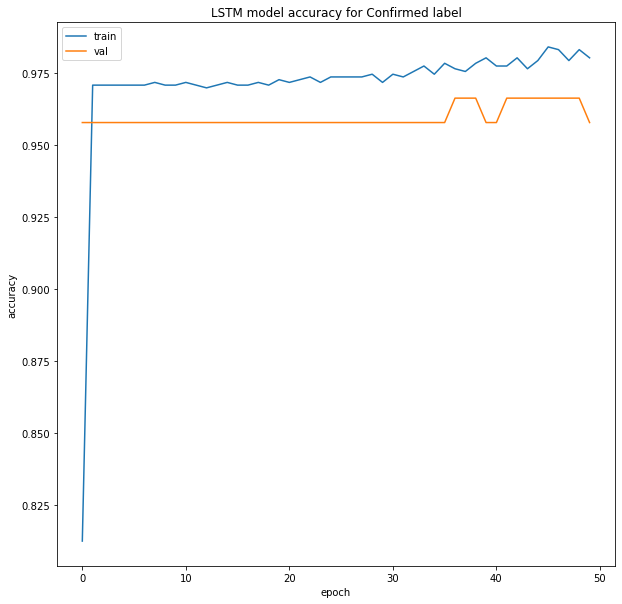

In [95]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy for Confirmed label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_model_accuracy_Confirmed.png")

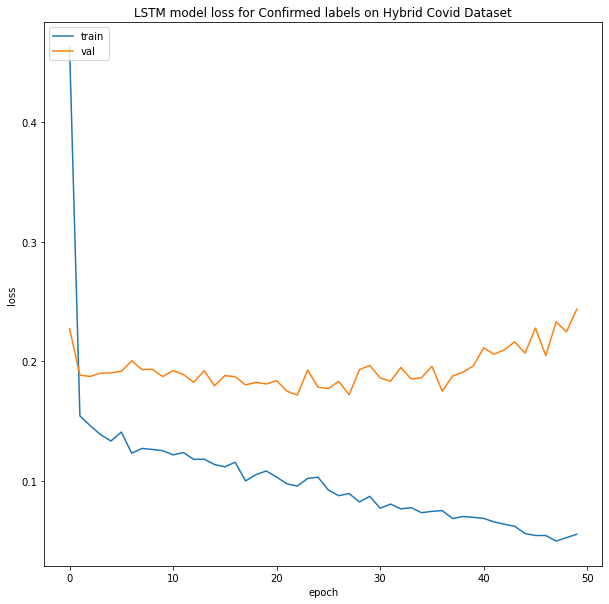

In [96]:
# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss for Confirmed labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("LSTM_model_loss_Confirmed.png")

In [97]:
#Checking accuracy on test data
LSTM_Model_Confirmed.evaluate(X_test6, Y_test6, batch_size=20)

207/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5347128531666122, 0.92753625]

### Model 2 - Hyperparameter Selection Using LeakyReLU - Recovered Label

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 50)                1100      
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 50)              

Epoch 54/100
1055/1055 - 0s - loss: 0.5166 - accuracy: 0.7194 - val_loss: 0.5077 - val_accuracy: 0.7373
Epoch 55/100
1055/1055 - 0s - loss: 0.5089 - accuracy: 0.7308 - val_loss: 0.5040 - val_accuracy: 0.7373
Epoch 56/100
1055/1055 - 0s - loss: 0.5197 - accuracy: 0.7422 - val_loss: 0.5013 - val_accuracy: 0.7458
Epoch 57/100
1055/1055 - 0s - loss: 0.5146 - accuracy: 0.7081 - val_loss: 0.4981 - val_accuracy: 0.7373
Epoch 58/100
1055/1055 - 0s - loss: 0.5043 - accuracy: 0.7280 - val_loss: 0.4959 - val_accuracy: 0.7373
Epoch 59/100
1055/1055 - 0s - loss: 0.5131 - accuracy: 0.7223 - val_loss: 0.4940 - val_accuracy: 0.7288
Epoch 60/100
1055/1055 - 0s - loss: 0.5052 - accuracy: 0.7365 - val_loss: 0.4947 - val_accuracy: 0.7458
Epoch 61/100
1055/1055 - 0s - loss: 0.4927 - accuracy: 0.7289 - val_loss: 0.4936 - val_accuracy: 0.7288
Epoch 62/100
1055/1055 - 0s - loss: 0.5075 - accuracy: 0.7327 - val_loss: 0.4927 - val_accuracy: 0.7288
Epoch 63/100
1055/1055 - 0s - loss: 0.5166 - accuracy: 0.7213 - 

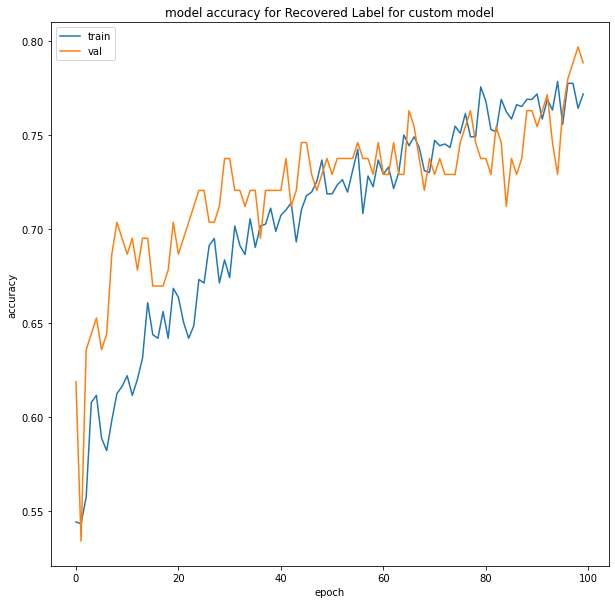

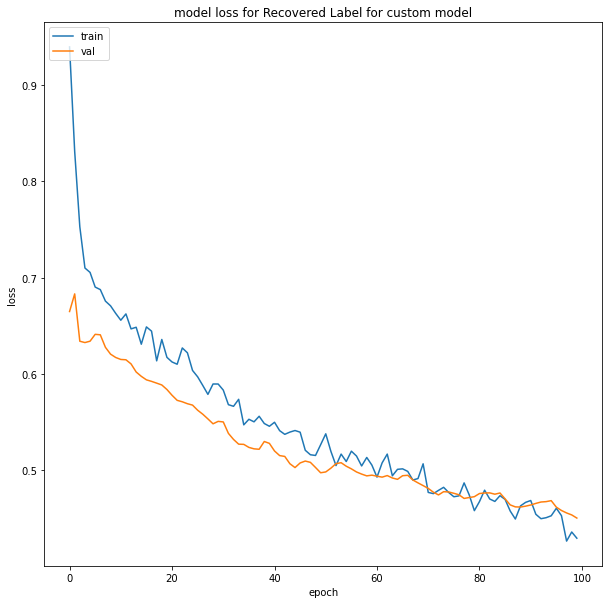

In [112]:
in_shape = X_train2.shape[1]
out_shape = y_train_Recovered.shape[1]

custom_model = Sequential([
    layers.Dense(50, input_shape=(input_shape,)),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

custom_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(custom_model.summary())

# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = custom_model.fit(X_train2, y_train_Recovered, epochs=100, batch_size=256, validation_data=(X_val2,y_val_Recovered), verbose=2, callbacks=[es])

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy for Recovered Label for custom model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy_Recovered_LeakyReLu.png")

# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for Recovered Label for custom model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("model_loss_Recovered_LeakyReLu.png")

### Model 3 - Hyperparameter Selection Using ReLU - Recovered Label

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 50)                1100      
_________________________________________________________________
dropout_45 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_46 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_47 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 50)              

Epoch 61/500
1055/1055 - 0s - loss: 0.7250 - accuracy: 0.5517 - val_loss: 0.6894 - val_accuracy: 0.6356
Epoch 62/500
1055/1055 - 0s - loss: 0.7334 - accuracy: 0.5839 - val_loss: 0.6900 - val_accuracy: 0.6356
Epoch 63/500
1055/1055 - 0s - loss: 0.7389 - accuracy: 0.5706 - val_loss: 0.6901 - val_accuracy: 0.6356
Epoch 64/500
1055/1055 - 0s - loss: 0.7577 - accuracy: 0.5782 - val_loss: 0.6898 - val_accuracy: 0.6356
Epoch 65/500
1055/1055 - 0s - loss: 0.7596 - accuracy: 0.5308 - val_loss: 0.6898 - val_accuracy: 0.6356
Epoch 66/500
1055/1055 - 0s - loss: 0.7352 - accuracy: 0.5848 - val_loss: 0.6897 - val_accuracy: 0.6356
Epoch 67/500
1055/1055 - 0s - loss: 0.7700 - accuracy: 0.5450 - val_loss: 0.6896 - val_accuracy: 0.6356
Epoch 68/500
1055/1055 - 0s - loss: 0.7482 - accuracy: 0.5460 - val_loss: 0.6895 - val_accuracy: 0.6356
Epoch 69/500
1055/1055 - 0s - loss: 0.7452 - accuracy: 0.5592 - val_loss: 0.6902 - val_accuracy: 0.6356
Epoch 70/500
1055/1055 - 0s - loss: 0.7584 - accuracy: 0.5583 - 

Epoch 140/500
1055/1055 - 0s - loss: 0.6888 - accuracy: 0.6171 - val_loss: 0.6884 - val_accuracy: 0.6356
Epoch 141/500
1055/1055 - 0s - loss: 0.7063 - accuracy: 0.5697 - val_loss: 0.6883 - val_accuracy: 0.6356
Epoch 142/500
1055/1055 - 0s - loss: 0.7048 - accuracy: 0.5735 - val_loss: 0.6884 - val_accuracy: 0.6356
Epoch 143/500
1055/1055 - 0s - loss: 0.7020 - accuracy: 0.5801 - val_loss: 0.6884 - val_accuracy: 0.6356
Epoch 144/500
1055/1055 - 0s - loss: 0.7071 - accuracy: 0.5801 - val_loss: 0.6885 - val_accuracy: 0.6356
Epoch 145/500
1055/1055 - 0s - loss: 0.7123 - accuracy: 0.5716 - val_loss: 0.6886 - val_accuracy: 0.6356
Epoch 146/500
1055/1055 - 0s - loss: 0.6906 - accuracy: 0.5953 - val_loss: 0.6885 - val_accuracy: 0.6356
Epoch 147/500
1055/1055 - 0s - loss: 0.7152 - accuracy: 0.5507 - val_loss: 0.6885 - val_accuracy: 0.6356
Epoch 148/500
1055/1055 - 0s - loss: 0.6794 - accuracy: 0.6028 - val_loss: 0.6885 - val_accuracy: 0.6356
Epoch 149/500
1055/1055 - 0s - loss: 0.7043 - accuracy:

1055/1055 - 0s - loss: 0.6866 - accuracy: 0.6000 - val_loss: 0.6853 - val_accuracy: 0.6356
Epoch 219/500
1055/1055 - 0s - loss: 0.6967 - accuracy: 0.5801 - val_loss: 0.6853 - val_accuracy: 0.6356
Epoch 220/500
1055/1055 - 0s - loss: 0.6901 - accuracy: 0.5858 - val_loss: 0.6853 - val_accuracy: 0.6356
Epoch 221/500
1055/1055 - 0s - loss: 0.6946 - accuracy: 0.5972 - val_loss: 0.6853 - val_accuracy: 0.6356
Epoch 222/500
1055/1055 - 0s - loss: 0.6828 - accuracy: 0.5962 - val_loss: 0.6853 - val_accuracy: 0.6356
Epoch 223/500
1055/1055 - 0s - loss: 0.6968 - accuracy: 0.5725 - val_loss: 0.6852 - val_accuracy: 0.6356
Epoch 224/500
1055/1055 - 0s - loss: 0.7036 - accuracy: 0.5716 - val_loss: 0.6851 - val_accuracy: 0.6356
Epoch 225/500
1055/1055 - 0s - loss: 0.6922 - accuracy: 0.5953 - val_loss: 0.6852 - val_accuracy: 0.6356
Epoch 226/500
1055/1055 - 0s - loss: 0.7054 - accuracy: 0.5848 - val_loss: 0.6851 - val_accuracy: 0.6356
Epoch 227/500
1055/1055 - 0s - loss: 0.6796 - accuracy: 0.5953 - val_

Epoch 297/500
1055/1055 - 0s - loss: 0.6718 - accuracy: 0.6009 - val_loss: 0.6838 - val_accuracy: 0.6441
Epoch 298/500
1055/1055 - 0s - loss: 0.6861 - accuracy: 0.5858 - val_loss: 0.6836 - val_accuracy: 0.6441
Epoch 299/500
1055/1055 - 0s - loss: 0.6960 - accuracy: 0.5867 - val_loss: 0.6833 - val_accuracy: 0.6441
Epoch 300/500
1055/1055 - 0s - loss: 0.6823 - accuracy: 0.5943 - val_loss: 0.6832 - val_accuracy: 0.6441
Epoch 301/500
1055/1055 - 0s - loss: 0.6739 - accuracy: 0.6142 - val_loss: 0.6832 - val_accuracy: 0.6441
Epoch 302/500
1055/1055 - 0s - loss: 0.6877 - accuracy: 0.6009 - val_loss: 0.6831 - val_accuracy: 0.6441
Epoch 303/500
1055/1055 - 0s - loss: 0.6889 - accuracy: 0.6019 - val_loss: 0.6829 - val_accuracy: 0.6441
Epoch 304/500
1055/1055 - 0s - loss: 0.6907 - accuracy: 0.5915 - val_loss: 0.6829 - val_accuracy: 0.6441
Epoch 305/500
1055/1055 - 0s - loss: 0.6807 - accuracy: 0.6028 - val_loss: 0.6829 - val_accuracy: 0.6441
Epoch 306/500
1055/1055 - 0s - loss: 0.6830 - accuracy:

1055/1055 - 0s - loss: 0.6830 - accuracy: 0.6133 - val_loss: 0.6813 - val_accuracy: 0.6441
Epoch 376/500
1055/1055 - 0s - loss: 0.6667 - accuracy: 0.6000 - val_loss: 0.6814 - val_accuracy: 0.6441
Epoch 377/500
1055/1055 - 0s - loss: 0.6719 - accuracy: 0.5991 - val_loss: 0.6814 - val_accuracy: 0.6441
Epoch 378/500
1055/1055 - 0s - loss: 0.6826 - accuracy: 0.5972 - val_loss: 0.6813 - val_accuracy: 0.6441
Epoch 379/500
1055/1055 - 0s - loss: 0.6680 - accuracy: 0.6019 - val_loss: 0.6813 - val_accuracy: 0.6441
Epoch 380/500
1055/1055 - 0s - loss: 0.6781 - accuracy: 0.6047 - val_loss: 0.6813 - val_accuracy: 0.6441
Epoch 381/500
1055/1055 - 0s - loss: 0.6749 - accuracy: 0.6019 - val_loss: 0.6811 - val_accuracy: 0.6441
Epoch 382/500
1055/1055 - 0s - loss: 0.6857 - accuracy: 0.5896 - val_loss: 0.6812 - val_accuracy: 0.6441
Epoch 383/500
1055/1055 - 0s - loss: 0.6750 - accuracy: 0.6104 - val_loss: 0.6812 - val_accuracy: 0.6441
Epoch 384/500
1055/1055 - 0s - loss: 0.6944 - accuracy: 0.5886 - val_

Epoch 454/500
1055/1055 - 0s - loss: 0.6718 - accuracy: 0.6104 - val_loss: 0.6808 - val_accuracy: 0.6441
Epoch 455/500
1055/1055 - 0s - loss: 0.6782 - accuracy: 0.6009 - val_loss: 0.6808 - val_accuracy: 0.6441
Epoch 456/500
1055/1055 - 0s - loss: 0.6776 - accuracy: 0.6028 - val_loss: 0.6807 - val_accuracy: 0.6441
Epoch 457/500
1055/1055 - 0s - loss: 0.6755 - accuracy: 0.6028 - val_loss: 0.6807 - val_accuracy: 0.6441
Epoch 458/500
1055/1055 - 0s - loss: 0.6805 - accuracy: 0.6095 - val_loss: 0.6807 - val_accuracy: 0.6441
Epoch 459/500
1055/1055 - 0s - loss: 0.6670 - accuracy: 0.6256 - val_loss: 0.6806 - val_accuracy: 0.6441
Epoch 460/500
1055/1055 - 0s - loss: 0.6818 - accuracy: 0.6009 - val_loss: 0.6806 - val_accuracy: 0.6441
Epoch 461/500
1055/1055 - 0s - loss: 0.6742 - accuracy: 0.6057 - val_loss: 0.6806 - val_accuracy: 0.6441
Epoch 462/500
1055/1055 - 0s - loss: 0.6731 - accuracy: 0.5981 - val_loss: 0.6805 - val_accuracy: 0.6441
Epoch 463/500
1055/1055 - 0s - loss: 0.6764 - accuracy:

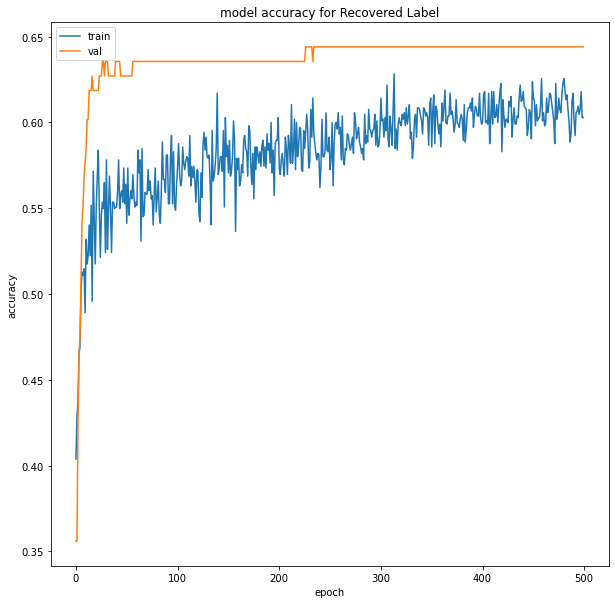

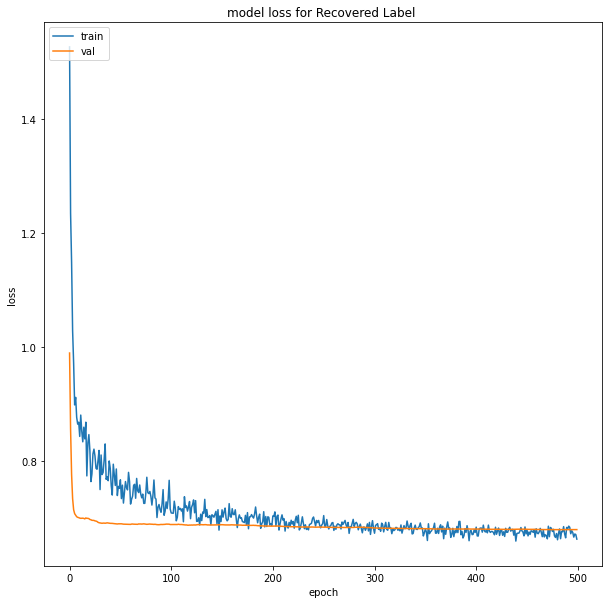

In [114]:
in_shape = X_train2.shape[1]
out_shape = y_train_Recovered.shape[1]

custom_model_relu = Sequential([
    layers.Dense(50, activation='relu', input_shape=(input_shape,)),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.SGD(lr=0.001)

custom_model_relu.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(custom_model_relu.summary())

# fit the network
history = custom_model_relu.fit(X_train2, Y_train2, epochs=500, batch_size=256, validation_data=(X_val2,y_val_Recovered), verbose=2)

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy for Recovered Label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy_Recovered_ReLu.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for Recovered Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Recovered_ReLu.png")

### Model 4: Final Custom Model - Recovered Label

In [53]:
input_shape = X_train2.shape[1]
out_shape = y_train_Recovered.shape[1]

final_model_Rec = Sequential([
    layers.Dense(50, activation='relu', input_shape=(input_shape,) ),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

final_model_Rec.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(final_model_Rec.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                1100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2

In [54]:
%%time
# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = final_model_Rec.fit(X_train2, y_train_Recovered, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Recovered), verbose=1, callbacks=[es])

# list all data in history
print(history.history.keys())

Train on 1055 samples, validate on 118 samples
Epoch 1/100
1055/1055 [==============================] - 4s 4ms/sample - loss: 0.8327 - accuracy: 0.5052 - val_loss: 0.6727 - val_accuracy: 0.6525
Epoch 2/100
1055/1055 [==============================] - 0s 195us/sample - loss: 0.7430 - accuracy: 0.5943 - val_loss: 0.6574 - val_accuracy: 0.6525
Epoch 3/100
1055/1055 [==============================] - 0s 210us/sample - loss: 0.7064 - accuracy: 0.6076 - val_loss: 0.6561 - val_accuracy: 0.6525
Epoch 4/100
1055/1055 [==============================] - 0s 162us/sample - loss: 0.6716 - accuracy: 0.6038 - val_loss: 0.6620 - val_accuracy: 0.6525
Epoch 5/100
1055/1055 [==============================] - 0s 171us/sample - loss: 0.6956 - accuracy: 0.5725 - val_loss: 0.6634 - val_accuracy: 0.6271
Epoch 6/100
1055/1055 [==============================] - 0s 146us/sample - loss: 0.6763 - accuracy: 0.5915 - val_loss: 0.6588 - val_accuracy: 0.6525
Epoch 7/100
1055/1055 [==============================] - 0s 1

1055/1055 [==============================] - 0s 128us/sample - loss: 0.5437 - accuracy: 0.7156 - val_loss: 0.5039 - val_accuracy: 0.7119
Epoch 55/100
1055/1055 [==============================] - 0s 173us/sample - loss: 0.5270 - accuracy: 0.7033 - val_loss: 0.5044 - val_accuracy: 0.7119
Epoch 56/100
1055/1055 [==============================] - 0s 175us/sample - loss: 0.5154 - accuracy: 0.7118 - val_loss: 0.4989 - val_accuracy: 0.7203
Epoch 57/100
1055/1055 [==============================] - 0s 165us/sample - loss: 0.5267 - accuracy: 0.7147 - val_loss: 0.4981 - val_accuracy: 0.7203
Epoch 58/100
1055/1055 [==============================] - 0s 171us/sample - loss: 0.5298 - accuracy: 0.7033 - val_loss: 0.4934 - val_accuracy: 0.7203
Epoch 59/100
1055/1055 [==============================] - 0s 292us/sample - loss: 0.5082 - accuracy: 0.7251 - val_loss: 0.4868 - val_accuracy: 0.7203
Epoch 60/100
1055/1055 [==============================] - 0s 253us/sample - loss: 0.4977 - accuracy: 0.7289 - val

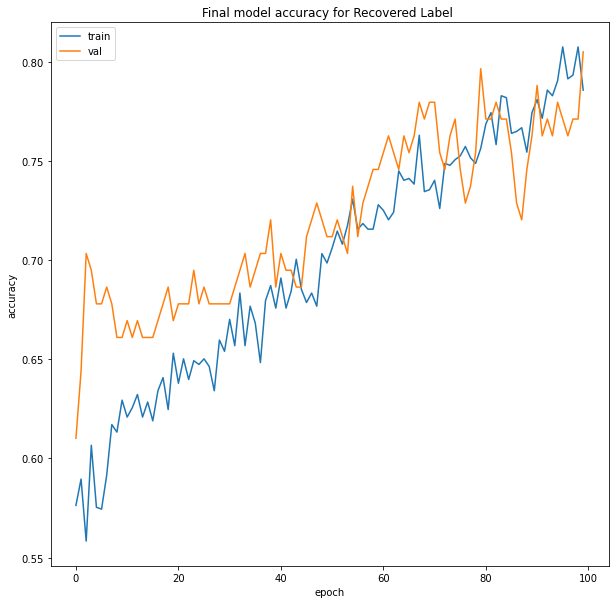

In [117]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final model accuracy for Recovered Label ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_accuracy_Recovered.png")

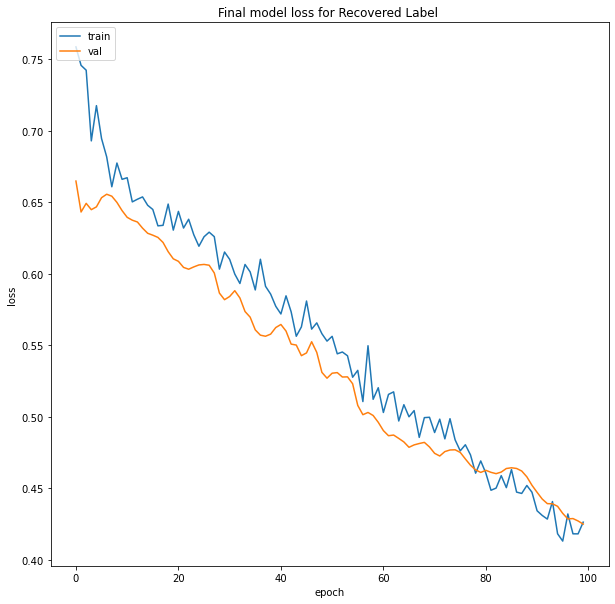

In [118]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Recovered Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Recovered.png")

In [119]:
%%time
results = final_model_Rec.evaluate(X_test1, y_test_Recovered, batch_size=128)
print("test loss, test acc:", results)

207/207 [==============================] - 0s 86us/sample - loss: 0.4022 - accuracy: 0.8116
test loss, test acc: [0.40220032380398923, 0.8115942]
CPU times: user 22.9 ms, sys: 6.81 ms, total: 29.7 ms
Wall time: 30.1 ms


### Final Custom Model - Deaths Label

In [55]:
input_shape = X_train2.shape[1]
out_shape = y_train_Deaths.shape[1]

final_model_Deaths = Sequential([
    layers.Dense(50, activation='relu', input_shape=(input_shape,) ),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

final_model_Deaths.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(final_model_Deaths.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                1100      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)               

In [56]:
%%time
# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = final_model_Deaths.fit(X_train2, y_train_Deaths, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Deaths), verbose=1, callbacks=[es])

# list all data in history
print(history.history.keys())

Train on 1055 samples, validate on 118 samples
Epoch 1/100
1055/1055 [==============================] - 5s 5ms/sample - loss: 1.2919 - accuracy: 0.3659 - val_loss: 0.5544 - val_accuracy: 0.8644
Epoch 2/100
1055/1055 [==============================] - 0s 211us/sample - loss: 0.5260 - accuracy: 0.8095 - val_loss: 0.6539 - val_accuracy: 0.8644
Epoch 3/100
1055/1055 [==============================] - 0s 258us/sample - loss: 0.4778 - accuracy: 0.8853 - val_loss: 0.6958 - val_accuracy: 0.8644
Epoch 4/100
1055/1055 [==============================] - 0s 256us/sample - loss: 0.4556 - accuracy: 0.9043 - val_loss: 0.6171 - val_accuracy: 0.8644
Epoch 5/100
1055/1055 [==============================] - 0s 262us/sample - loss: 0.4475 - accuracy: 0.9024 - val_loss: 0.5143 - val_accuracy: 0.8644
Epoch 6/100
1055/1055 [==============================] - 0s 231us/sample - loss: 0.4145 - accuracy: 0.9033 - val_loss: 0.4593 - val_accuracy: 0.8644
Epoch 7/100
1055/1055 [==============================] - 0s 3

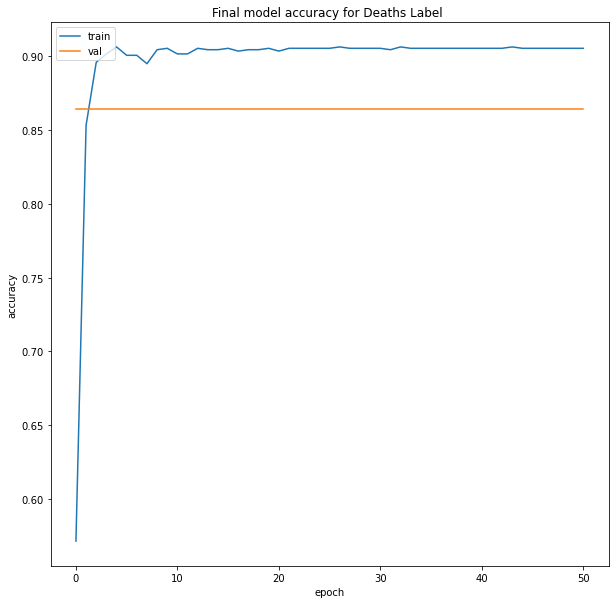

In [124]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final model accuracy for Deaths Label ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_accuracy_Deaths.png")

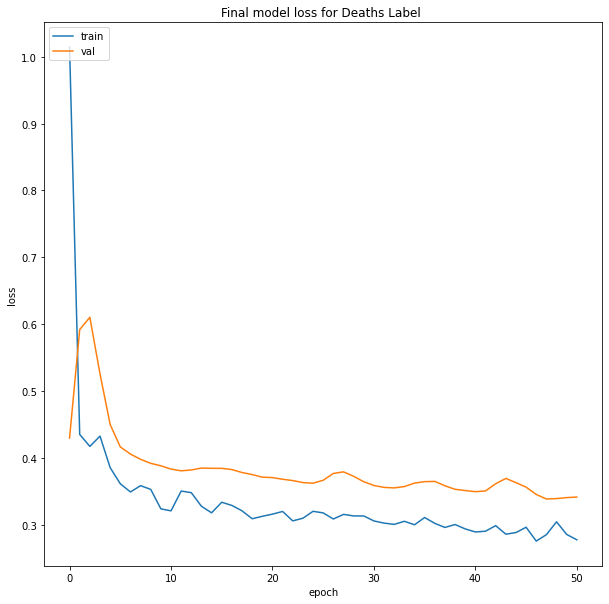

In [125]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Deaths Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Deaths.png")

In [126]:
%%time
results = final_model_Deaths.evaluate(X_test1, y_test_Deaths, batch_size=128)
print("test loss, test acc:", results)

207/207 [==============================] - 0s 109us/sample - loss: 0.2590 - accuracy: 0.9034
test loss, test acc: [0.25897994954228976, 0.90338165]
CPU times: user 23.2 ms, sys: 6.47 ms, total: 29.6 ms
Wall time: 34.4 ms


### Final Custom Model - Confirmed Label

In [57]:
input_shape = X_train2.shape[1]
out_shape = y_train_Confirmed.shape[1]

final_model_Confirmed = Sequential([
    layers.Dense(50, activation='relu', input_shape=(input_shape,) ),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

final_model_Confirmed.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(final_model_Confirmed.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 50)                1100      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)               

In [58]:
%%time
# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = final_model_Confirmed.fit(X_train2, y_train_Confirmed, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Confirmed), verbose=1, callbacks=[es])

# list all data in history
print(history.history.keys())

Train on 1055 samples, validate on 118 samples
Epoch 1/100
1055/1055 [==============================] - 6s 6ms/sample - loss: 0.4151 - accuracy: 0.8142 - val_loss: 0.1932 - val_accuracy: 0.9661
Epoch 2/100
1055/1055 [==============================] - 0s 322us/sample - loss: 0.2489 - accuracy: 0.9583 - val_loss: 0.2271 - val_accuracy: 0.9661
Epoch 3/100
1055/1055 [==============================] - 0s 291us/sample - loss: 0.2649 - accuracy: 0.9602 - val_loss: 0.2247 - val_accuracy: 0.9661
Epoch 4/100
1055/1055 [==============================] - 0s 245us/sample - loss: 0.2479 - accuracy: 0.9621 - val_loss: 0.1964 - val_accuracy: 0.9661
Epoch 5/100
1055/1055 [==============================] - 0s 248us/sample - loss: 0.2338 - accuracy: 0.9611 - val_loss: 0.1772 - val_accuracy: 0.9661
Epoch 6/100
1055/1055 [==============================] - 0s 415us/sample - loss: 0.2145 - accuracy: 0.9602 - val_loss: 0.1758 - val_accuracy: 0.9661
Epoch 7/100
1055/1055 [==============================] - 0s 3

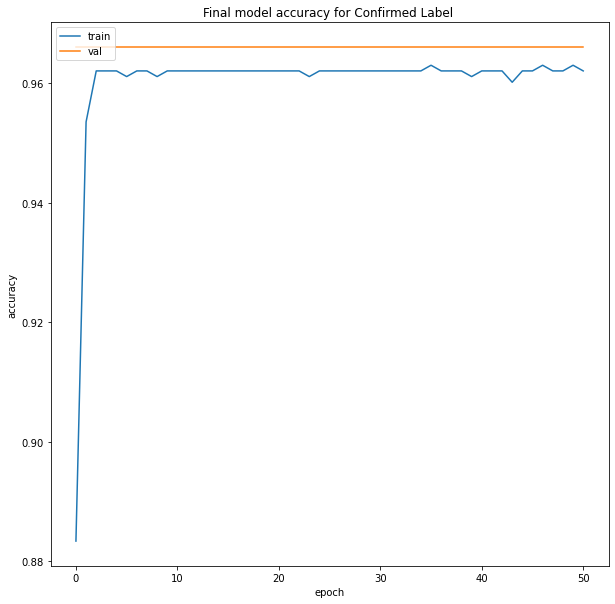

In [132]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final model accuracy for Confirmed Label ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_accuracy_Confirmed.png")

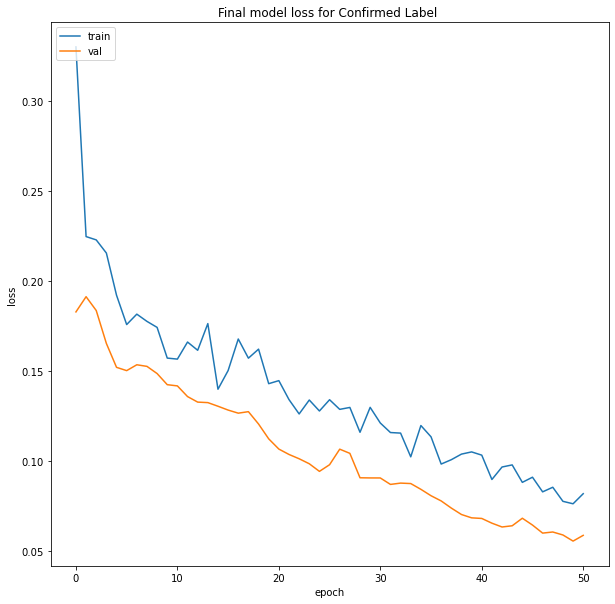

In [131]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Confirmed Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Confirmed.png")

In [133]:
%%time
results = final_model_Confirmed.evaluate(X_test1, y_test_Confirmed, batch_size=128)
print("test loss, test acc:", results)

207/207 [==============================] - 0s 82us/sample - loss: 0.0471 - accuracy: 0.9662
test loss, test acc: [0.04708397649408538, 0.9661836]
CPU times: user 23.9 ms, sys: 7.96 ms, total: 31.9 ms
Wall time: 29.6 ms


### 2.3 [CM5] Kaggle Submission

In [59]:
#loading test dataset for Kaggle submission
covid_test = pd.read_csv("dkmacovid_kaggletest_features.csv")

In [60]:
#Type-casting the population and population density data into float data type
covid_test[['Resident Population 2020 Census', 'Population Density 2020 Census']] = covid_test[['Resident Population 2020 Census', 
                                                                                      'Population Density 2020 Census']].replace({",":""},
                                                                                       regex=True).apply(pd.to_numeric,1)

In [61]:
# Getting the relative difference values for specific quantitative attributes with respect to the state as done 
#for the traning dataset

covid_test = ReativeFeature(covid_test, 'Active')
covid_test = ReativeFeature(covid_test, 'Case_Fatality_Ratio')
covid_test = ReativeFeature(covid_test, 'Incident_Rate')
covid_test = ReativeFeature(covid_test, 'Total_Test_Results')
covid_test = ReativeFeature(covid_test, 'Testing_Rate')

covid_test

,Id,Day,State ID,State,Lat,Long_,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
0,0,2,14,Illinois,40.3495,-88.9861,957138,7697.015291,13436652,1.867428,106035.68340,12812508.0,230.8,14,97,1.0,1.000000,1.000000,1.0,1.00000
1,5,3,14,Illinois,40.3495,-88.9861,961499,7732.282519,13482117,1.869933,106394.47160,12812508.0,230.8,14,97,4361.0,0.002505,35.267228,45465.0,358.78820
2,10,4,14,Illinois,40.3495,-88.9861,966468,7772.205747,13530371,1.869466,106775.26930,12812508.0,230.8,14,97,4969.0,-0.000467,39.923228,48254.0,380.79770
3,15,5,14,Illinois,40.3495,-88.9861,973157,7826.175891,13617454,1.871700,107462.48700,12812508.0,230.8,14,97,6689.0,0.002233,53.970144,87083.0,687.21770
4,20,6,14,Illinois,40.3495,-88.9861,980553,7885.906848,13698428,1.874835,108101.49540,12812508.0,230.8,14,97,7396.0,0.003135,59.730957,80974.0,639.00840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,129,27,48,Washington,47.4009,-121.4905,301078,4009.104264,4446844,1.379349,58396.67084,7705281.0,115.9,24,100,1763.0,0.006285,23.729814,22614.0,296.97069
146,134,28,48,Washington,47.4009,-121.4905,303566,4042.197310,4470215,1.378452,58703.58257,7705281.0,115.9,24,100,2488.0,-0.000897,33.093046,23371.0,306.91173
147,139,29,48,Washington,47.4009,-121.4905,305516,4068.356574,4495463,1.383146,59035.14337,7705281.0,115.9,24,100,1950.0,0.004694,26.159264,25248.0,331.56080
148,144,30,48,Washington,47.4009,-121.4905,307312,4091.941935,4524221,1.375174,59412.79805,7705281.0,115.9,24,100,1796.0,-0.007972,23.585361,28758.0,377.65468


In [62]:
#dropping certain columns as done in the training dataset
covid_test_update = covid_test[covid_test.columns.difference(['Lat', 'Long_', 'Id', 'State'])]
covid_test_update

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,Relative_Total_Test_Results,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results
0,957138,1.867428,2,14,7697.015291,230.8,1.0,1.000000,1.000000,1.00000,1.0,12812508.0,97,14,106035.68340,13436652
1,961499,1.869933,3,14,7732.282519,230.8,4361.0,0.002505,35.267228,358.78820,45465.0,12812508.0,97,14,106394.47160,13482117
2,966468,1.869466,4,14,7772.205747,230.8,4969.0,-0.000467,39.923228,380.79770,48254.0,12812508.0,97,14,106775.26930,13530371
3,973157,1.871700,5,14,7826.175891,230.8,6689.0,0.002233,53.970144,687.21770,87083.0,12812508.0,97,14,107462.48700,13617454
4,980553,1.874835,6,14,7885.906848,230.8,7396.0,0.003135,59.730957,639.00840,80974.0,12812508.0,97,14,108101.49540,13698428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,301078,1.379349,27,24,4009.104264,115.9,1763.0,0.006285,23.729814,296.97069,22614.0,7705281.0,100,48,58396.67084,4446844
146,303566,1.378452,28,24,4042.197310,115.9,2488.0,-0.000897,33.093046,306.91173,23371.0,7705281.0,100,48,58703.58257,4470215
147,305516,1.383146,29,24,4068.356574,115.9,1950.0,0.004694,26.159264,331.56080,25248.0,7705281.0,100,48,59035.14337,4495463
148,307312,1.375174,30,24,4091.941935,115.9,1796.0,-0.007972,23.585361,377.65468,28758.0,7705281.0,100,48,59412.79805,4524221


In [63]:
scaler = preprocessing.StandardScaler()
scaled_covid_test=covid_test_update.copy()
scaled_covid_test[['Active','Case_Fatality_Ratio','Incident_Rate', 
                 'Density Rank 2020 Census','Population Density 2020 Census',
                 'Relative_Active', 'Relative_Case_Fatality_Ratio','Total_Test_Results',
                 'Relative_Incident_Rate','Relative_Testing_Rate', 
                 'Testing_Rate', 'Resident Population 2020 Census', 
                 'Relative_Total_Test_Results', 'State ID','SexRatio']]=pd.DataFrame(scaler.fit_transform(scaled_covid_test[['Active','Case_Fatality_Ratio',                              
                                                    'Incident_Rate', 'Density Rank 2020 Census',                           
                                                    'Population Density 2020 Census',
                                                    'Relative_Active', 'Relative_Case_Fatality_Ratio',
                                                    'Total_Test_Results','Relative_Incident_Rate', 
                                                    'Relative_Testing_Rate', 
                                                    'Testing_Rate', 'Resident Population 2020 Census', 
                                                    'Relative_Total_Test_Results','State ID','SexRatio']]))
scaled_covid_test

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,Relative_Total_Test_Results,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results
0,1.630365,1.718143,2,-1.392419,-0.034670,1.605706,-0.410182,5.375847,-1.643657,-1.436507,-1.044578,0.094176,-0.559017,-1.283315,1.252685,0.874530
1,1.642290,1.729474,3,-1.392419,-0.019131,1.605706,0.717905,-0.182509,-0.409462,-0.020155,-0.095284,0.094176,-0.559017,-1.283315,1.265333,0.882366
2,1.655878,1.727361,4,-1.392419,-0.001540,1.605706,0.875217,-0.199070,-0.241768,0.066973,-0.037049,0.094176,-0.559017,-1.283315,1.278757,0.890682
3,1.674170,1.737463,5,-1.392419,0.022241,1.605706,1.320242,-0.184024,0.264156,1.279977,0.773706,0.094176,-0.559017,-1.283315,1.302983,0.905691
4,1.694395,1.751645,6,-1.392419,0.048560,1.605706,1.503168,-0.178997,0.471642,1.089134,0.646149,0.094176,-0.559017,-1.283315,1.325509,0.919647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.163676,-0.489574,27,-0.103142,-1.659654,-0.352846,0.045710,-0.161443,-0.825003,-0.264868,-0.572416,-0.465357,1.118034,1.013144,-0.426668,-0.674859
146,-0.156872,-0.493630,28,-0.103142,-1.645072,-0.352846,0.233293,-0.201463,-0.487769,-0.225515,-0.556610,-0.465357,1.118034,1.013144,-0.415848,-0.670832
147,-0.151540,-0.472399,29,-0.103142,-1.633546,-0.352846,0.094094,-0.170313,-0.737502,-0.127938,-0.517417,-0.465357,1.118034,1.013144,-0.404160,-0.666480
148,-0.146628,-0.508459,30,-0.103142,-1.623153,-0.352846,0.054248,-0.240892,-0.830205,0.054531,-0.444128,-0.465357,1.118034,1.013144,-0.390847,-0.661524


In [64]:
covid_test_pca = pca_covid_data.transform(scaled_covid_test)
print(covid_test_pca.shape)

(150, 10)


In [65]:
#Making the hybrid test dataset by using covid_test_update along with first 5 PCA components.

x = covid_test_pca[:, 0].tolist()
scaled_covid_test.loc[:, 'PCA1'] = x
x = covid_test_pca[:, 1].tolist()
scaled_covid_test.loc[:, 'PCA2'] = x
x = covid_test_pca[:, 2].tolist()
scaled_covid_test.loc[:, 'PCA3'] = x
x = covid_test_pca[:, 3].tolist()
scaled_covid_test.loc[:, 'PCA4'] = x
x = covid_test_pca[:, 4].tolist()
scaled_covid_test.loc[:, 'PCA5'] = x

In [66]:
recovered_labels = y_train_Recovered
confirmed_labels = y_train_Confirmed
deaths_labels = y_train_Deaths
recovered_labels

,Recovered
1143,1
1341,0
1207,0
334,1
335,1
...,...
1254,1
1058,0
357,0
447,1


### For "Recovered" class

In [67]:
scaled_covid_test.shape

(150, 21)

In [68]:
final_model_Rec.fit(X_train2, y_train_Recovered, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Recovered), verbose=1, callbacks=[es])
recovered_test_predict = (final_model_Rec.predict(scaled_covid_test, batch_size=20, verbose=1)> 0.5).astype("int32")
recovered_test_predict = pd.DataFrame(recovered_test_predict)[0]
recovered_test_predict


Train on 1055 samples, validate on 118 samples
Epoch 1/100
1055/1055 [==============================] - 0s 156us/sample - loss: 0.3815 - accuracy: 0.8227 - val_loss: 0.3818 - val_accuracy: 0.8220
Epoch 2/100
1055/1055 [==============================] - 0s 314us/sample - loss: 0.4079 - accuracy: 0.8066 - val_loss: 0.3763 - val_accuracy: 0.8305
Epoch 3/100
1055/1055 [==============================] - 0s 331us/sample - loss: 0.3815 - accuracy: 0.8246 - val_loss: 0.3701 - val_accuracy: 0.8390
Epoch 4/100
1055/1055 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.80 - 0s 278us/sample - loss: 0.3788 - accuracy: 0.8133 - val_loss: 0.3678 - val_accuracy: 0.8305
Epoch 5/100
1055/1055 [==============================] - 0s 309us/sample - loss: 0.3720 - accuracy: 0.8294 - val_loss: 0.3717 - val_accuracy: 0.8390
Epoch 6/100
1055/1055 [==============================] - 0s 237us/sample - loss: 0.3572 - accuracy: 0.8351 - val_loss: 0.3759 - val_accuracy: 0.8136
Epoch 7/100
1055/

Epoch 54/100
1055/1055 [==============================] - 0s 265us/sample - loss: 0.1677 - accuracy: 0.9365 - val_loss: 0.1865 - val_accuracy: 0.9322
Epoch 55/100
1055/1055 [==============================] - 0s 204us/sample - loss: 0.2078 - accuracy: 0.9118 - val_loss: 0.1931 - val_accuracy: 0.9322
Epoch 56/100
1055/1055 [==============================] - 0s 309us/sample - loss: 0.1950 - accuracy: 0.9355 - val_loss: 0.1807 - val_accuracy: 0.9322
Epoch 57/100
1055/1055 [==============================] - 0s 212us/sample - loss: 0.1713 - accuracy: 0.9393 - val_loss: 0.1749 - val_accuracy: 0.9322
Epoch 58/100
1055/1055 [==============================] - 0s 200us/sample - loss: 0.1845 - accuracy: 0.9346 - val_loss: 0.1659 - val_accuracy: 0.9492
Epoch 59/100
1055/1055 [==============================] - 0s 161us/sample - loss: 0.1664 - accuracy: 0.9498 - val_loss: 0.1585 - val_accuracy: 0.9492
Epoch 60/100
1055/1055 [==============================] - 0s 194us/sample - loss: 0.1866 - accuracy:

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    0
Name: 0, Length: 150, dtype: int32

In [57]:
default_model_Recovered.fit(X_train2,y_train_Recovered, epochs = 100,
                            validation_data=(X_val2,y_val_Recovered), 
                            verbose=0, batch_size=50)
recovered_predict_test = (default_model_Recovered.predict(scaled_covid_test, batch_size=20, verbose=1)> 0.5).astype("int32")


150/150 [==============================] - 0s 110us/sample


In [60]:
recovered_predict_test=pd.DataFrame(recovered_predict_test)[0]
recovered_predict_test

0      1
1      1
2      1
3      1
4      1
      ..
145    1
146    1
147    1
148    1
149    1
Name: 0, Length: 150, dtype: int32

### For "Confirmed" class

In [69]:
final_model_Confirmed.fit(X_train2, y_train_Confirmed, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Confirmed), verbose=1, callbacks=[es])
confirmed_test_predict = (final_model_Confirmed.predict(scaled_covid_test, batch_size=20, verbose=1)> 0.5).astype("int32")
confirmed_test_predict = pd.DataFrame(confirmed_test_predict)[0]
confirmed_test_predict

Train on 1055 samples, validate on 118 samples
Epoch 1/100
1055/1055 [==============================] - 0s 148us/sample - loss: 0.1091 - accuracy: 0.9621 - val_loss: 0.0857 - val_accuracy: 0.9661
Epoch 2/100
1055/1055 [==============================] - 0s 194us/sample - loss: 0.1091 - accuracy: 0.9621 - val_loss: 0.0860 - val_accuracy: 0.9661
Epoch 3/100
1055/1055 [==============================] - 0s 224us/sample - loss: 0.0895 - accuracy: 0.9621 - val_loss: 0.0889 - val_accuracy: 0.9661
Epoch 4/100
1055/1055 [==============================] - 0s 170us/sample - loss: 0.1022 - accuracy: 0.9621 - val_loss: 0.0847 - val_accuracy: 0.9661
Epoch 5/100
1055/1055 [==============================] - 0s 183us/sample - loss: 0.0918 - accuracy: 0.9621 - val_loss: 0.0803 - val_accuracy: 0.9661
Epoch 6/100
1055/1055 [==============================] - 0s 168us/sample - loss: 0.0946 - accuracy: 0.9630 - val_loss: 0.0798 - val_accuracy: 0.9661
Epoch 7/100
1055/1055 [==============================] - 0s

1055/1055 [==============================] - 0s 170us/sample - loss: 0.0342 - accuracy: 0.9858 - val_loss: 0.0386 - val_accuracy: 0.9915
Epoch 55/100
1055/1055 [==============================] - 0s 198us/sample - loss: 0.0467 - accuracy: 0.9829 - val_loss: 0.0386 - val_accuracy: 0.9915
Epoch 56/100
1055/1055 [==============================] - 0s 183us/sample - loss: 0.0441 - accuracy: 0.9848 - val_loss: 0.0365 - val_accuracy: 0.9915
Epoch 57/100
1055/1055 [==============================] - 0s 174us/sample - loss: 0.0326 - accuracy: 0.9810 - val_loss: 0.0409 - val_accuracy: 0.9915
Epoch 58/100
1055/1055 [==============================] - 0s 139us/sample - loss: 0.0447 - accuracy: 0.9820 - val_loss: 0.0510 - val_accuracy: 0.9915
Epoch 59/100
1055/1055 [==============================] - 0s 169us/sample - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.0507 - val_accuracy: 0.9915
Epoch 60/100
1055/1055 [==============================] - 0s 232us/sample - loss: 0.0368 - accuracy: 0.9877 - val

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    0
Name: 0, Length: 150, dtype: int32

In [65]:
default_model_Confirmed.fit(X_train2,y_train_Confirmed, epochs = 100,
                            validation_data=(X_val2,y_val_Confirmed), 
                            verbose=0, batch_size=50)
confirmed_predict_test = (default_model_Confirmed.predict(scaled_covid_test, batch_size=20, verbose=1) > 0.5).astype("int32")
confirmed_predict_test = pd.DataFrame(confirmed_predict_test)[0]
#confirmed_predict_test = confirmed_predict_test.astype(int)

150/150 [==============================] - 0s 813us/sample


In [66]:
confirmed_predict_test

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    1
Name: 0, Length: 150, dtype: int32

### For "Deaths" class

In [70]:
final_model_Deaths.fit(X_train2, y_train_Deaths, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Deaths), verbose=1, callbacks=[es])
deaths_test_predict = (final_model_Deaths.predict(scaled_covid_test, batch_size=20, verbose=1)> 0.5).astype("int32")
deaths_test_predict = pd.DataFrame(deaths_test_predict)[0]
deaths_test_predict

Train on 1055 samples, validate on 118 samples
Epoch 1/100
1055/1055 [==============================] - 0s 131us/sample - loss: 0.2836 - accuracy: 0.9052 - val_loss: 0.3407 - val_accuracy: 0.8644
Epoch 2/100
1055/1055 [==============================] - 0s 172us/sample - loss: 0.2733 - accuracy: 0.9052 - val_loss: 0.3447 - val_accuracy: 0.8644
Epoch 3/100
1055/1055 [==============================] - 0s 183us/sample - loss: 0.2732 - accuracy: 0.9052 - val_loss: 0.3437 - val_accuracy: 0.8644
Epoch 4/100
1055/1055 [==============================] - 0s 233us/sample - loss: 0.2793 - accuracy: 0.9043 - val_loss: 0.3392 - val_accuracy: 0.8644
Epoch 5/100
1055/1055 [==============================] - 0s 159us/sample - loss: 0.2774 - accuracy: 0.9052 - val_loss: 0.3344 - val_accuracy: 0.8644
Epoch 6/100
1055/1055 [==============================] - 0s 212us/sample - loss: 0.2614 - accuracy: 0.9052 - val_loss: 0.3300 - val_accuracy: 0.8644
Epoch 7/100
1055/1055 [==============================] - 0s

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    0
Name: 0, Length: 150, dtype: int32

In [61]:
default_model_Deaths.fit(X_train2,y_train_Deaths, epochs = 100,
                            validation_data=(X_val2,y_val_Deaths), 
                            verbose=0, batch_size=50)
deaths_predict_test = (default_model_Deaths.predict(scaled_covid_test, batch_size=20, verbose=1)> 0.5).astype("int32")
deaths_predict_test = pd.DataFrame(deaths_predict_test)[0]
#deaths_predict_test = deaths_predict_test.astype(int)

150/150 [==============================] - 0s 129us/sample


In [62]:
deaths_predict_test

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    1
Name: 0, Length: 150, dtype: int32

In [71]:
kaggle_output = pd.DataFrame({
    'Id': covid_test.Id,
    'Confirmed': confirmed_test_predict,
    'Deaths': deaths_test_predict,
    'Recovered': recovered_test_predict
})

In [67]:
kaggle_output_default_model = pd.DataFrame({
    'Id': covid_test.Id,
    'Confirmed': confirmed_predict_test,
    'Deaths': deaths_predict_test,
    'Recovered': recovered_predict_test
})

In [72]:
kaggle_output.to_csv("dkma_submission_file.csv", index=False)

In [68]:
kaggle_output_default_model.to_csv("dkma_output_submit_DefaultDNN.csv", index=False)

## PART II of the assignment  - Fashion MNIST Dataset

In [22]:
#Importing additional libraries needed for this part of the assignment
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization,MaxPooling2D,MaxPool2D
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback,ModelCheckpoint,EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [9]:
def acc_plot(history, name):
    plt.figure(figsize=(10,6))
    plt.plot(history['accuracy'], label='training accuracy')
    plt.plot(history['loss'], label='training loss')    
    plt.plot(history['val_accuracy'], label='validation accuracy')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title(name + ' Accuracy and Loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.savefig(name +'_Result.png', bbox_inches='tight', dpi=300)
    return plt.show()

In [10]:
import time
class TimeHistory(keras.callbacks.Callback):
    def train_begin(self, logs={}):
        self.times = []

    def epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
# Loading Dataset
trainX = pd.read_csv('trainX.csv')
testX = pd.read_csv('testX.csv')
trainy = pd.read_csv('trainy.csv')
testy = pd.read_csv('testy.csv')

df = pd.merge(trainX,trainy).iloc[:,1:].copy()
df_test = pd.merge(testX,testy).iloc[:,1:].copy()

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,9,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
print('Train: ', df.shape)
print('Test: ', df_test.shape)
df[' Label'].value_counts()

Train:  (60000, 785)
Test:  (10000, 785)


4    12067
2    11994
1    11986
3    11978
0    11975
Name:  Label, dtype: int64

In [14]:
# Split the Train dataset into train and validation data (taking 10% for testing):
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.15, random_state=0, shuffle=True)

### Verifying if any labels are null on train, val and test sets

In [15]:
print("Null label values in train set: ",y_train.iloc[:,0].isnull().any().sum())
print("Null label values in validation set: ",y_val.iloc[:,0].isnull().any().sum())
print("Null label values in test set: ",df_test.iloc[:,0].isnull().any().sum())


Null label values in train set:  0
Null label values in validation set:  0
Null label values in test set:  0


In [16]:
clothing = {0 : 'Label1',
            1 : 'Label2',
            2 : 'Label3',
            3 : 'Label4',
            4 : 'Label5',}

### Exploring the training data

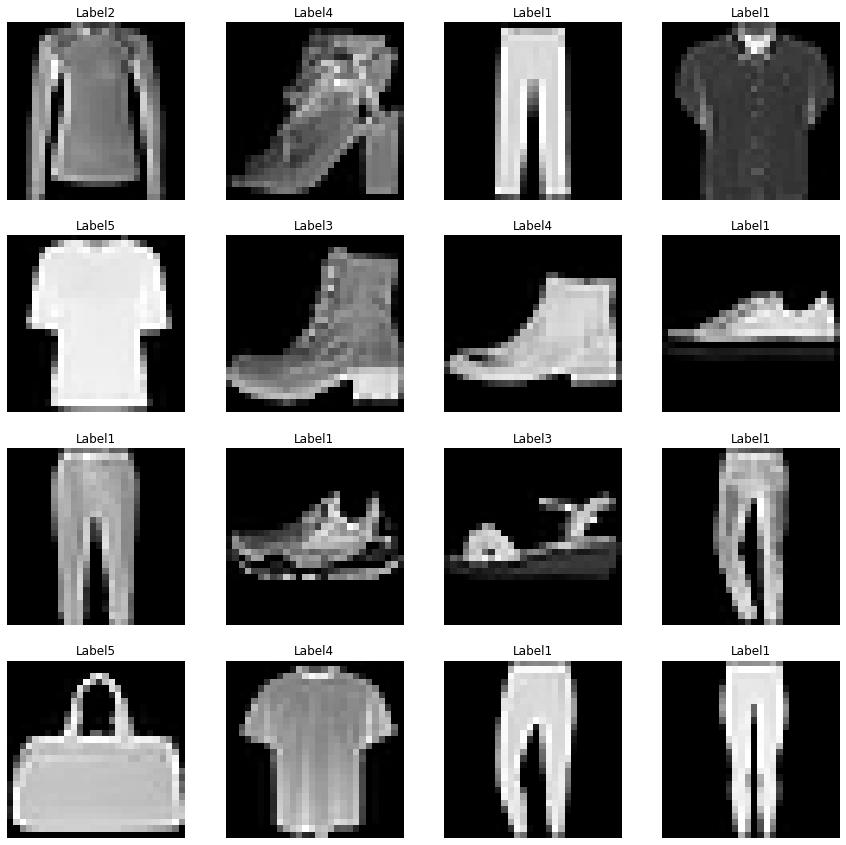

In [170]:
fig, axes = plt.subplots(4, 4, figsize = (15,15))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df.drop(' Label', axis=1).values[index].reshape(28,28)
        cloths = df[' Label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

In [17]:
#reshape of data needed as various layers of cnn need l*b*no of channels
#here -1 means  want numpy to figure it out

X_train = MinMaxScaler().fit_transform(X_train.iloc[:,1:]).reshape((-1, 28, 28, 1))
X_val = MinMaxScaler().fit_transform(X_val.iloc[:,1:]).reshape((-1, 28, 28, 1))
X_test = MinMaxScaler().fit_transform(testX.iloc[:,1:]).reshape((-1, 28, 28, 1))

y_train = y_train.iloc[:,1:]
y_val = y_val.iloc[:,1:]
y_test = testy.iloc[:,1:]

In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(51000, 28, 28, 1)
(9000, 28, 28, 1)
(10000, 28, 28, 1)
(51000, 1)
(9000, 1)
(10000, 1)


In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(51000, 5)
(9000, 5)
(10000, 5)


In [20]:
import time
start_train = time.time()

In [23]:
# used to save the best model in keras.model
checkpointer = ModelCheckpoint(filepath="keras.model", verbose=0, save_best_only=True)

In [24]:
monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=10, verbose=1, 
                        mode='auto',restore_best_weights = True)

### Description of the Model Elements we have incorporated

1) At First, we have utilized Sequential Keras API which is merely a linear stack of layers. We add one layer at a time starting from the input layer.
2) Following that,we have added Convolutional Layers, which are the Building blocks of a CNN model. Convolutional Layers have sets of Independent Filters whose dimensions can be set manually. These Filters when convolved over the Input Image produce Feature/Activation Maps.

#### Some HyperParameters included in this layer are: 
number of filters, Dimensions of Filter (F), Stride (S), Padding(P) , Activation Function etc. which we have entered as input manually. Let the Input Volume Size be denoted by (W) ,

We have used relu as the activation function in our default model since we know it facilitates resolving vanishing gradient problem and also allows model to learn faster and perform better.

Thus, the Output will have Dimensions given by -->

#### (Height, Width) = ( ( W − F + 2P ) / S ) + 1

Here, the Depth equals to Number of Filters Specified.
3) Following the previous layer, we have added Pooling Layers, which are used majorly for Dimensionality Reduction or DownSampling the Input. Pooling layers are utilized when we have lot of Input Features. It reduces the amount of Parameters and Computational power, thus minimizing Overfitting. These along with Convolutional layers are able to learn more Complex features of the Image. For pooling layers, height and width is decided using the following formula while depth is the same as that of the input layer.

#### (Height, Width) = ( ( W − F + 2P ) / S ) + 1

4) Batch normalization: By using batch normalization, we acheive Zero mean and Variance one. This also scales down the outliers and facilitates the network to learn the dataset features in a distributed manner, without relying on a particular exemplified weight. This helps in enhancing the generalizability as well.

5) Dropout: Regularization technique that penalizes certain parameters. It randomly drops certain nodes and re-aligns the weights. Remaining neurons learn more attributes and reduce the dependency on one specific node. Usually, dropout is set between 0.2 - 0.5.

6) Flatten: Maps the input to a 1-Dimesnional vector. Post this, we have added some Fully connected Layers after some convolutional/pooling layers. It combines all the Features of the Previous Layers.

7) Output layer: Units equivalent to the number of classes to be identified. We have utilized 'softmax' activation function because it is a Multi-Class Classification problem.

8) Learning Rate Decay: We have used LearningRateScheduler here, which accepts the step decay function as an argument and returns updated learning rates for optmizing at each epoch stage. Basically it outputs a new learning rate at every epoch stage.

### Model 1: CNN

In [19]:
cnn2_model = Sequential()
cnn2_model.add(Conv2D(32, kernel_size=(7,7),
                 padding='valid',
                 activation='relu',
                 input_shape=(28,28,1)))
cnn2_model.add(Conv2D(128, (7, 7), activation='relu'))
cnn2_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn2_model.add(BatchNormalization())
cnn2_model.add(Dropout(0.5))

cnn2_model.add(Conv2D(64, (7, 7), activation='relu'))
cnn2_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn2_model.add(BatchNormalization())
cnn2_model.add(Dropout(0.5))

cnn2_model.add(Flatten())
cnn2_model.add(Dense(5, activation='softmax'))

cnn2_model.summary()

2021-08-09 14:59:50.028159: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-09 14:59:50.028586: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       200832    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          401472    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0

In [20]:
time_callback= TimeHistory()
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
es = EarlyStopping(monitor='val_acc', mode='auto', verbose =1, baseline =0.80)
callbacks = [reduce_lr, es,time_callback]

# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Compiling the model
cnn2_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Fit the Model
historyCNN2 = cnn2_model.fit(X_train, y_train, batch_size=128, epochs = 40, 
                             validation_data = (X_val, y_val), 
                             verbose=2,
                              callbacks=[reduce_lr,time_callback])

Train on 51000 samples, validate on 9000 samples
Epoch 1/40
51000/51000 - 321s - loss: 0.7460 - accuracy: 0.7016 - val_loss: 0.7472 - val_accuracy: 0.7172
Epoch 2/40
51000/51000 - 327s - loss: 0.5284 - accuracy: 0.7886 - val_loss: 0.4526 - val_accuracy: 0.8221
Epoch 3/40
51000/51000 - 315s - loss: 0.4807 - accuracy: 0.8071 - val_loss: 0.9493 - val_accuracy: 0.6317
Epoch 4/40
51000/51000 - 313s - loss: 0.4462 - accuracy: 0.8213 - val_loss: 0.4307 - val_accuracy: 0.8238
Epoch 5/40
51000/51000 - 316s - loss: 0.4181 - accuracy: 0.8350 - val_loss: 0.4253 - val_accuracy: 0.8192
Epoch 6/40
51000/51000 - 314s - loss: 0.4036 - accuracy: 0.8414 - val_loss: 0.3519 - val_accuracy: 0.8580
Epoch 7/40
51000/51000 - 331s - loss: 0.3839 - accuracy: 0.8479 - val_loss: 0.3352 - val_accuracy: 0.8662
Epoch 8/40
51000/51000 - 324s - loss: 0.3746 - accuracy: 0.8517 - val_loss: 0.5298 - val_accuracy: 0.7898
Epoch 9/40
51000/51000 - 324s - loss: 0.3578 - accuracy: 0.8595 - val_loss: 0.4881 - val_accuracy: 0.79

In [23]:
startModel_1 = time.time()
score = cnn2_model.evaluate(X_test, y_test)
endModel_1 = time.time()
elapsed_model1 = endModel_1-startModel_1

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [24]:
print('Test Loss using CNN Model: {:.4f}'.format(score[0]))
print('Test Accuracy using CNN Model: {:.4f}'.format(score[1]))
print('Time taken to run the CNN Model on the Test set: ', elapsed_model1, " seconds")

Test Loss using CNN Model: 0.2732
Test Accuracy using CNN Model: 0.8929
Time taken to run the CNN Model on the Test set:  20.73229193687439  seconds


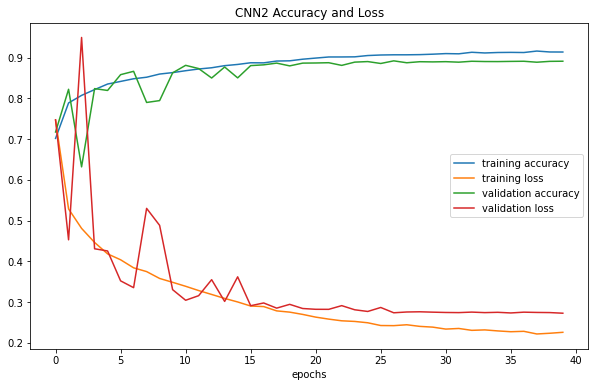

In [25]:
acc_plot(historyCNN2.history, 'CNN2')

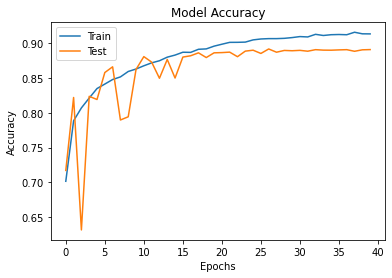

In [26]:
plt.plot(historyCNN2.history['accuracy'])
plt.plot(historyCNN2.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

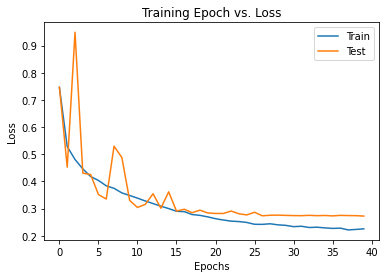

In [27]:
plt.plot(historyCNN2.history['loss'])
plt.plot(historyCNN2.history['val_loss'])
plt.title("Training Epoch vs. Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [34]:
import sys
!{sys.executable} -m pip install pydot

In [35]:
!{sys.executable} -m pip install pydotplus
!{sys.executable} -m pip install graphviz

     |████████████████████████████████| 278 kB 2.4 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=3cf33b0e2441e84dd3c2b15d6c4271a684103447aa147d16b038608b6c80e181
  Stored in directory: /Users/snigdhakakkar/Library/Caches/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


In [38]:
from tensorflow.keras.utils import to_categorical, plot_model

In [39]:
plot_model(cnn2_model, show_shapes=True, expand_nested=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_cnn_improved'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/Users/snigdhakakkar/opt/anaconda2/envs/tf/Assigment_4/saved_model/fmnist_cnn_improved


### Observations:
From the above model, we can deduce that the above CNN model utilizes 3 convolutional layers and 1 dense / fully connected layer. We achieve a validation accuracy of 89.10% in 40 epochs.

As the model is run and the number of epochs are increased, we observe a sharp fall in the training and validation loss while seeing an increase in the respective accuracies. The loss and accuracy eventually plateau and we see a deteoriation in both after epoch 30.

After evaluating the performance on the training(85%) and validation dataset(15%), we evaluate our model on the provided test data. We observe that the loss and accuracy on the test set is quite similar to the one obtained in the validation set 89.29%. We also find that the time taken to evaluate our model on the test set takes about 20.73 seconds.

We have set a goal of obtaining at the minimum of 80% accuracy and/or loss below 0.4 both on the validation and the test dataset.

Thus, in the next model, we made a few modifications to generalize better and avoid overfitting in the model. We reduced the number of epochs to 30 as the default model has accuracy and loss plateauing at around epoch = 30.

We have tried the below two models:

1. CNN model as described above with EarlyStopping to avoid overfitting and LeakyReLU activation function.
2. RESNET50 model 

### Model 2: CNN model  with EarlyStopping to avoid overfitting

In [ ]:
model = Sequential()  
model.add(layers.Flatten(input_shape=input_shape.shape[1:]))  
model.add(layers.Dense(100)) # no activation here
model.add(layers.LeakyReLU(alpha=0.3)) # activation layer here instead 
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(50)) # no activation here
model.add(layers.LeakyReLU(alpha=0.3))  # activation layer here instead
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(num_classes, activation='softmax'))

In [47]:
from tensorflow.keras.layers import LeakyReLU

cnn2_model2 = Sequential()
cnn2_model2.add(Conv2D(32, kernel_size=(7,7),
                 padding='valid',
                 activation = LeakyReLU(),
                 input_shape=(28,28,1)))
cnn2_model2.add(Conv2D(128, (7, 7), activation = LeakyReLU()))
cnn2_model2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2_model2.add(BatchNormalization())
cnn2_model2.add(Dropout(0.5))

cnn2_model2.add(Conv2D(64, (7, 7), activation = LeakyReLU()))
cnn2_model2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2_model2.add(BatchNormalization())
cnn2_model2.add(Dropout(0.5))

cnn2_model2.add(Flatten())
cnn2_model2.add(Dense(5, activation='softmax'))

cnn2_model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 22, 22, 32)        1600      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       200832    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 64)          401472    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)         

In [48]:
time_callback= TimeHistory()
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
es = EarlyStopping(monitor='val_acc', mode='auto', verbose =1, baseline =0.80)
callbacks = [reduce_lr, es,time_callback]

# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Compiling the model
cnn2_model2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [49]:
# Fit the Model
historyCNN3 = cnn2_model2.fit(X_train, y_train, batch_size=128, epochs = 30, 
                             validation_data = (X_val, y_val), 
                             verbose=2,
                              callbacks=[reduce_lr,time_callback])

Train on 51000 samples, validate on 9000 samples
Epoch 1/30
51000/51000 - 351s - loss: 0.8401 - accuracy: 0.6570 - val_loss: 0.7983 - val_accuracy: 0.6534
Epoch 2/30
51000/51000 - 348s - loss: 0.6001 - accuracy: 0.7547 - val_loss: 0.5536 - val_accuracy: 0.7590
Epoch 3/30
51000/51000 - 344s - loss: 0.5396 - accuracy: 0.7805 - val_loss: 0.6690 - val_accuracy: 0.7300
Epoch 4/30
51000/51000 - 363s - loss: 0.4992 - accuracy: 0.7991 - val_loss: 0.5848 - val_accuracy: 0.7459
Epoch 5/30
51000/51000 - 347s - loss: 0.4750 - accuracy: 0.8088 - val_loss: 0.4839 - val_accuracy: 0.7988
Epoch 6/30
51000/51000 - 342s - loss: 0.4647 - accuracy: 0.8153 - val_loss: 0.5584 - val_accuracy: 0.7747
Epoch 7/30
51000/51000 - 369s - loss: 0.4435 - accuracy: 0.8214 - val_loss: 0.4449 - val_accuracy: 0.8150
Epoch 8/30
51000/51000 - 345s - loss: 0.4268 - accuracy: 0.8311 - val_loss: 0.4052 - val_accuracy: 0.8397
Epoch 9/30
51000/51000 - 347s - loss: 0.4126 - accuracy: 0.8354 - val_loss: 0.4058 - val_accuracy: 0.83

In [50]:
startModel_2 = time.time()
score = cnn2_model2.evaluate(X_test, y_test)
endModel_2 = time.time()
elapsed_model2 = endModel_2-startModel_2

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [51]:
print('Test Loss using CNN Model (with LeakyReLU activation): {:.4f}'.format(score[0]))
print('Test Accuracy using CNN Model (with LeakyReLU activation): {:.4f}'.format(score[1]))
print('Time taken to run the CNN Model (with LeakyReLU activation) on the Test set: ', elapsed_model2, " seconds")

Test Loss using CNN Model (with LeakyReLU activation): 0.3149
Test Accuracy using CNN Model (with LeakyReLU activation): 0.8779
Time taken to run the CNN Model (with LeakyReLU activation) on the Test set:  26.975409984588623  seconds


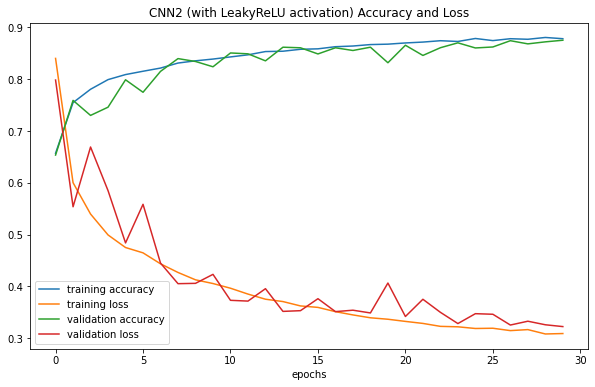

In [52]:
acc_plot(historyCNN3.history, 'CNN2 (with LeakyReLU activation)')

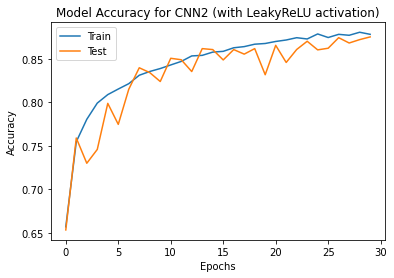

In [53]:
plt.plot(historyCNN3.history['accuracy'])
plt.plot(historyCNN3.history['val_accuracy'])
plt.title("Model Accuracy for CNN2 (with LeakyReLU activation)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

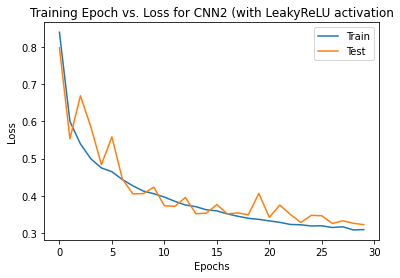

In [54]:
plt.plot(historyCNN3.history['loss'])
plt.plot(historyCNN3.history['val_loss'])
plt.title("Training Epoch vs. Loss for CNN2 (with LeakyReLU activation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [55]:

save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_cnn_improved_leakyrelu'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/Users/snigdhakakkar/opt/anaconda2/envs/tf/Assigment_4/saved_model/fmnist_cnn_improved_leakyrelu


### Model 3: RESNET

In [3]:
#Importing the libraries
import pandas as pd
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

# Deep Learning Libraries
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, Input, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import AveragePooling2D

In [4]:
def identity_block(X, f, filters, stage, block):
   
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [5]:
def convolutional_block(X, f, filters, stage, block, s = 2):
   
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [6]:
def ResNet50(input_shape=(28, 28, 1), classes=1):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"'''
    X = AveragePooling2D((2,2), name="avg_pool", padding="same")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.25)(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [7]:
RNN_model = ResNet50(input_shape = (28, 28, 1), classes = 5)
RNN_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
RNN_model.summary()

2021-08-10 09:51:16.100884: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-10 09:51:16.103618: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [25]:
historyRNN = RNN_model.fit(X_train, y_train,batch_size=1024,epochs=35,shuffle = True,validation_data=(X_val, y_val))

Train on 51000 samples, validate on 9000 samples
Epoch 1/35
51000/51000 [==============================] - 1312s 26ms/sample - loss: 0.9179 - accuracy: 0.6526 - val_loss: 1.6815 - val_accuracy: 0.1971
Epoch 2/35
51000/51000 [==============================] - 1229s 24ms/sample - loss: 0.4769 - accuracy: 0.8116 - val_loss: 1.8773 - val_accuracy: 0.1971
Epoch 3/35
51000/51000 [==============================] - 1194s 23ms/sample - loss: 0.3896 - accuracy: 0.8485 - val_loss: 1.8600 - val_accuracy: 0.1971
Epoch 4/35
51000/51000 [==============================] - 1018s 20ms/sample - loss: 0.3355 - accuracy: 0.8692 - val_loss: 1.7784 - val_accuracy: 0.1990
Epoch 5/35
51000/51000 [==============================] - 989s 19ms/sample - loss: 0.3016 - accuracy: 0.8839 - val_loss: 1.7978 - val_accuracy: 0.2857
Epoch 6/35
51000/51000 [==============================] - 1253s 25ms/sample - loss: 0.2608 - accuracy: 0.8997 - val_loss: 1.3064 - val_accuracy: 0.4179
Epoch 7/35
51000/51000 [================

In [26]:
score = RNN_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8043185574412346
Test accuracy: 0.8326


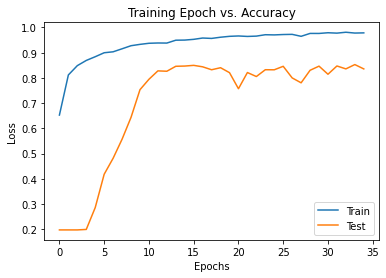

In [73]:
#  Visualize model accuracy
plt.plot(historyRNN.history['accuracy'])
plt.plot(historyRNN.history['val_accuracy'])
plt.title("Training Epoch vs. Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

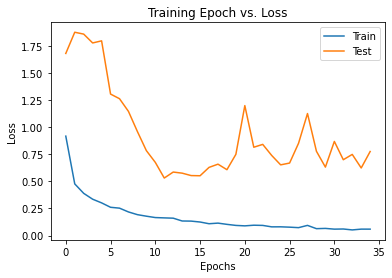

In [28]:
#  Visualize loss history / model loss
plt.plot(historyRNN.history['loss'])
plt.plot(historyRNN.history['val_loss'])
plt.title("Training Epoch vs. Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()